In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import StackingClassifier
import tensorflow as tf

import copy
from collections import defaultdict
from scipy.optimize import curve_fit
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

In [3]:
tf.random.set_seed(42)

In [4]:
seasons = []

for i in range(23):
    num = str(i).zfill(2)
    file_path = f'C:/Users/kamil/OneDrive/Dokumenty/studia/magisterka/data/season_{num}.csv'
    
    header_row = pd.read_csv(file_path, encoding='latin1', nrows=1)
    num_columns = len(header_row.columns)
    
    season = pd.read_csv(file_path, encoding='latin1', usecols=range(num_columns))
    
    print(f"Number of matches in season_{num}: {len(season)}")
    seasons.append(season)

Number of matches in season_00: 380
Number of matches in season_01: 380
Number of matches in season_02: 380
Number of matches in season_03: 380
Number of matches in season_04: 380
Number of matches in season_05: 380
Number of matches in season_06: 380
Number of matches in season_07: 380
Number of matches in season_08: 380
Number of matches in season_09: 380
Number of matches in season_10: 380
Number of matches in season_11: 380
Number of matches in season_12: 380
Number of matches in season_13: 380
Number of matches in season_14: 380
Number of matches in season_15: 380
Number of matches in season_16: 380
Number of matches in season_17: 380
Number of matches in season_18: 380
Number of matches in season_19: 380
Number of matches in season_20: 380
Number of matches in season_21: 380
Number of matches in season_22: 380


In [5]:
selected_columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
                    'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR',
                    'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA']

df = pd.DataFrame(columns=['season'] + selected_columns)

for i, season_df in enumerate(seasons):
    season_num = f'20{str(i).zfill(2)}'
    season_df_selected = season_df[selected_columns]
    season_df_selected.insert(0, 'season', season_num)
    df = pd.concat([df, season_df_selected], ignore_index=True)
    
df.loc[df['IWH'].isnull(), 'IWH'] = df['WHH']
df.loc[df['IWD'].isnull(), 'IWD'] = df['WHD']
df.loc[df['IWA'].isnull(), 'IWA'] = df['WHA']
        
df.drop(columns=['WHH', 'WHD', 'WHA'], inplace=True)

df = df.rename(columns={
    'Season' : 'season',
    'Date': 'date', 
    'HomeTeam': 'home_team', 
    'AwayTeam': 'away_team',
    'IWH': 'OH',
    'IWD': 'OD',
    'IWA': 'OA'
})    
    
df['season'] = df['season'].astype('int64')
df['FTHG'] = df['FTHG'].astype('int64')
df['FTAG'] = df['FTAG'].astype('int64')
df['FTR'] = df['FTR'].astype('string')
df['HTHG'] = df['HTHG'].astype('int64')
df['HTAG'] = df['HTAG'].astype('int64')
df['HS'] = df['HS'].astype('int64')
df['AS'] = df['AS'].astype('int64')
df['HST'] = df['HST'].astype('int64')
df['AST'] = df['AST'].astype('int64')
df['HC'] = df['HC'].astype('int64')
df['AC'] = df['AC'].astype('int64')
df['HF'] = df['HF'].astype('int64')
df['AF'] = df['AF'].astype('int64')
df['HY'] = df['HY'].astype('int64')
df['AY'] = df['AY'].astype('int64')
df['HR'] = df['HR'].astype('int64')
df['AR'] = df['AR'].astype('int64')

df['date_temp1'] = pd.to_datetime(df['date'], format='%d/%m/%y', errors='coerce')
df['date_temp2'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')
df['date'] = df['date_temp1']
df.loc[df['date'].isnull(), 'date'] = df['date_temp2']
df.drop(columns=['date_temp1', 'date_temp2'], inplace=True)

df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

df

# season - Match Season
# date - Match Date
# home_team - Home Team
# away_team - Away Team
# FTHG - Full Time Home Team Goals
# FTAG - Full Time Away Team Goals
# FTR - Full Time Result (H=Home Win, D=Draw, A=Away Win)
# HTHG - Half Time Home Team Goals
# HTAG - Half Time Away Team Goals
# HTR - Half Time Result (H=Home Win, D=Draw, A=Away Win)
# HS - Home Team Shots
# AS - Away Team Shots
# HST - Home Team Shots on Target
# AST - Away Team Shots on Target
# HC - Home Team Corners
# AC - Away Team Corners
# HF - Home Team Fouls Committed
# AF - Away Team Fouls Committed
# HY - Home Team Yellow Cards
# AY - Away Team Yellow Cards
# HR - Home Team Red Cards
# AR - Away Team Red Cards
# OH - Home Team Win Odds
# OD - Draw Odds
# OA - Away Team Win Odds

season       date    home_team      away_team  FTHG  FTAG FTR  HTHG  \
0       2000 2000-08-19     Charlton       Man City     4     0   H     2   
1       2000 2000-08-19      Chelsea       West Ham     4     2   H     1   
2       2000 2000-08-19     Coventry  Middlesbrough     1     3   A     1   
3       2000 2000-08-19        Derby    Southampton     2     2   D     1   
4       2000 2000-08-19        Leeds        Everton     2     0   H     2   
...      ...        ...          ...            ...   ...   ...  ..   ...   
8735    2022 2023-05-28    Brentford       Man City     1     0   H     0   
8736    2022 2023-05-28  Aston Villa       Brighton     2     1   H     2   
8737    2022 2023-05-28      Arsenal         Wolves     5     0   H     3   
8738    2022 2023-05-28      Chelsea      Newcastle     1     1   D     1   
8739    2022 2023-05-28  Southampton      Liverpool     4     4   D     2   

      HTAG HTR  ...  AC  HF  AF  HY  AY  HR  AR    OH   OD    OA  
0        0   H  ...   6  13  12   1   2   0   0  2.20  2.9  2.70  
1        0   H  ...   7  19  14   1   2   0   0  1.60  3.2  4.20  
2        1   D  ...   4  15  21   5   3   1   0  2.20  2.9  2.70  
3        2   A  ...   8  11  13   1   1   0   0  1.80  3.0  3.50  
4        0   H  ...   4  21  20   1   3   0   0  1.55  3.3  4.50  
...    ...  ..  ...  ..  ..  ..  ..  ..  ..  ..   ...  ...   ...  
8735     0   D  ...   4  12   8   4   0   0   0  3.80  3.9  1.90  
8736     1   H  ...   3  15  16   4   4   0   0  2.00  3.7  3.55  
8737     0   H  ...   4   8  11   0   0   0   0  1.43  4.6  7.75  
8738     1   D  ...   3   9  11   0   0   0   0  2.80  3.5  2.45  
8739     2   D  ...   9   4  10   0   2   0   0  6.25  5.0  1.45  

[8740 rows x 25 columns]

In [6]:
standings = pd.read_csv('C:/Users/kamil/OneDrive/Dokumenty/studia/magisterka/data/standings_2000_2022.csv')

standings['Season'] = standings['Season'].str[:4].astype('int64')
standings['Pos'] = standings['Pos'].astype('int64')

standings = standings[['Season', 'Pos', 'Team']]
standings = standings.rename(
    columns={'Season': 'season', 'Pos': 'position', 'Team': 'team'}
)

standings['team'] = standings['team'].replace('Manchester United', 'Man United')
standings['team'] = standings['team'].replace('Leeds United', 'Leeds')
standings['team'] = standings['team'].replace('Ipswich Town', 'Ipswich')
standings['team'] = standings['team'].replace('Charlton Athletic', 'Charlton')
standings['team'] = standings['team'].replace('Newcastle United', 'Newcastle')
standings['team'] = standings['team'].replace('Tottenham Hotspur', 'Tottenham')
standings['team'] = standings['team'].replace('Leicester City', 'Leicester')
standings['team'] = standings['team'].replace('West Ham United', 'West Ham')
standings['team'] = standings['team'].replace('Derby County', 'Derby')
standings['team'] = standings['team'].replace('Manchester City', 'Man City')
standings['team'] = standings['team'].replace('Coventry City', 'Coventry')
standings['team'] = standings['team'].replace('Bradford City', 'Bradford')
standings['team'] = standings['team'].replace('Blackburn Rovers', 'Blackburn')
standings['team'] = standings['team'].replace('Bolton Wanderers', 'Bolton')
standings['team'] = standings['team'].replace('Birmingham City', 'Birmingham')
standings['team'] = standings['team'].replace('West Bromwich Albion', 'West Brom')
standings['team'] = standings['team'].replace('Wolverhampton Wanderers', 'Wolves')
standings['team'] = standings['team'].replace('Norwich City', 'Norwich')
standings['team'] = standings['team'].replace('Wigan Athletic', 'Wigan')
standings['team'] = standings['team'].replace('Stoke City', 'Stoke')
standings['team'] = standings['team'].replace('Hull City', 'Hull')
standings['team'] = standings['team'].replace('Swansea City', 'Swansea')
standings['team'] = standings['team'].replace('Queens Park Rangers', 'QPR')
standings['team'] = standings['team'].replace('Cardiff City', 'Cardiff')
standings['team'] = standings['team'].replace('Brighton & Hove Albion', 'Brighton')
standings['team'] = standings['team'].replace('Huddersfield Town', 'Huddersfield')
standings['team'] = standings['team'].replace('Hull City', 'Hull')

standings

season  position           team
0      2000         1     Man United
1      2000         2        Arsenal
2      2000         3      Liverpool
3      2000         4          Leeds
4      2000         5        Ipswich
..      ...       ...            ...
455    2022        16  Nott'm Forest
456    2022        17        Everton
457    2022        18      Leicester
458    2022        19          Leeds
459    2022        20    Southampton

[460 rows x 3 columns]

In [7]:
unique_teams = pd.concat([df['home_team'], df['away_team']]).unique()
unique_teams

array(['Charlton', 'Chelsea', 'Coventry', 'Derby', 'Leeds', 'Leicester',
       'Liverpool', 'Sunderland', 'Tottenham', 'Man United', 'Arsenal',
       'Bradford', 'Ipswich', 'Middlesbrough', 'West Ham', 'Southampton',
       'Everton', 'Man City', 'Newcastle', 'Aston Villa', 'Bolton',
       'Blackburn', 'Fulham', 'Birmingham', 'West Brom', 'Portsmouth',
       'Wolves', 'Norwich', 'Crystal Palace', 'Wigan', 'Reading',
       'Sheffield United', 'Watford', 'Hull', 'Stoke', 'Burnley',
       'Blackpool', 'QPR', 'Swansea', 'Cardiff', 'Bournemouth',
       'Brighton', 'Huddersfield', 'Brentford', "Nott'm Forest"],
      dtype=object)

In [8]:
team_matches_dict = {}

for team in unique_teams:
    team_matches = df[df['home_team'].eq(team) | df['away_team'].eq(team)].copy()
    team_matches['team'] = team
    for index, row in team_matches.iterrows():
        if row['home_team'] == team:
            team_matches.at[index, 'opponent'] = row['away_team']
            team_matches.at[index, 'where'] = 'H'
            if row['FTR'] == 'H':
                team_matches.at[index, 'points'] = 3
            elif row['FTR'] == 'D':
                team_matches.at[index, 'points'] = 1
            elif row['FTR'] == 'A':
                team_matches.at[index, 'points'] = 0
            team_matches.at[index, 'GS'] = row['FTHG']
            team_matches.at[index, 'GC'] = row['FTAG']
            team_matches.at[index, 'S'] = row['HS']
            team_matches.at[index, 'OS'] = row['AS']
            team_matches.at[index, 'ST'] = row['HST']
            team_matches.at[index, 'OST'] = row['AST']
            team_matches.at[index, 'C'] = row['HC']
            team_matches.at[index, 'OC'] = row['AC']
        else:
            team_matches.at[index, 'opponent'] = row['home_team']
            team_matches.at[index, 'where'] = 'A'
            if row['FTR'] == 'H':
                team_matches.at[index, 'points'] = 0
            elif row['FTR'] == 'D':
                team_matches.at[index, 'points'] = 1
            elif row['FTR'] == 'A':
                team_matches.at[index, 'points'] = 3
            team_matches.at[index, 'GS'] = row['FTAG']
            team_matches.at[index, 'GC'] = row['FTHG']
            team_matches.at[index, 'S'] = row['AS']
            team_matches.at[index, 'OS'] = row['HS']
            team_matches.at[index, 'ST'] = row['AST']
            team_matches.at[index, 'OST'] = row['HST']
            team_matches.at[index, 'C'] = row['AC']
            team_matches.at[index, 'OC'] = row['HC']
    int_columns = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
    team_matches[int_columns] = team_matches[int_columns].astype(int)
    team_matches = team_matches.drop(['home_team', 'away_team', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'OH', 'OD', 'OA'],axis=1)
    team_matches_dict[team] = team_matches

In [9]:
for team, matches_df in team_matches_dict.items():
    matches_df['LSP'] = None
    for season, season_df in matches_df.groupby('season'):
        prev_season = season - 1
        if prev_season in standings['season'].unique():
            prev_season_standings = standings[standings['season'] == prev_season]
            team_standings = prev_season_standings[prev_season_standings['team'] == team]
            if not team_standings.empty:
                prev_season_position = team_standings['position'].iloc[0]
                matches_df.loc[matches_df['season'] == season, 'LSP'] = prev_season_position

for team, matches_df in team_matches_dict.items():
    matches_df['LSP'] = matches_df['LSP'].fillna(21).astype(int)
    # 21 dla drużyn które w poprzednim sezonie awansowały do ligi
    
team_matches_dict.get('Man United')

season       date        team     opponent where  points  GS  GC   S  \
9       2000 2000-08-20  Man United    Newcastle     H       3   2   0  19   
12      2000 2000-08-22  Man United      Ipswich     A       1   1   1  15   
27      2000 2000-08-26  Man United     West Ham     A       1   2   2   8   
32      2000 2000-09-05  Man United     Bradford     H       3   6   0  21   
40      2000 2000-09-09  Man United   Sunderland     H       3   3   0  15   
...      ...        ...         ...          ...   ...     ...  ..  ..  ..   
8703    2022 2023-05-07  Man United     West Ham     A       0   0   1  19   
8711    2022 2023-05-13  Man United       Wolves     H       3   2   0  27   
8719    2022 2023-05-20  Man United  Bournemouth     A       3   1   0  20   
8729    2022 2023-05-25  Man United      Chelsea     H       3   4   1  18   
8734    2022 2023-05-28  Man United       Fulham     H       3   2   1  21   

      OS  ST  OST   C  OC  LSP  
9      9   9    6   7   1   21  
12    13   6    8   6   4   21  
27    17   5    8   5   7   21  
32     6  12    4   5   1   21  
40     5   7    1   4   4   21  
...   ..  ..  ...  ..  ..  ...  
8703  15   4    4   6   5    6  
8711   5   9    0  11   7    6  
8719  10   5    4   6   3    6  
8729  14   9    5   3   4    6  
8734  10   8    3   5   4    6  

[874 rows x 15 columns]

In [10]:
def rolling_averages(team, cols, new_cols, number_of_games):
    team_df = team_matches_dict.get(team).sort_values('date')
    rolling_stats = team_df[cols].rolling(number_of_games, closed='left').mean()
    team_df[new_cols] = rolling_stats.values
    team_matches_dict[team] = team_df

    
cols = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
new_cols = [f'{c}_rolling' for c in cols]

for team in unique_teams:
    rolling_averages(team, cols, new_cols, 5)
    
team_matches_dict.get('Man United')

season       date        team     opponent where  points  GS  GC   S  \
9       2000 2000-08-20  Man United    Newcastle     H       3   2   0  19   
12      2000 2000-08-22  Man United      Ipswich     A       1   1   1  15   
27      2000 2000-08-26  Man United     West Ham     A       1   2   2   8   
32      2000 2000-09-05  Man United     Bradford     H       3   6   0  21   
40      2000 2000-09-09  Man United   Sunderland     H       3   3   0  15   
...      ...        ...         ...          ...   ...     ...  ..  ..  ..   
8703    2022 2023-05-07  Man United     West Ham     A       0   0   1  19   
8711    2022 2023-05-13  Man United       Wolves     H       3   2   0  27   
8719    2022 2023-05-20  Man United  Bournemouth     A       3   1   0  20   
8729    2022 2023-05-25  Man United      Chelsea     H       3   4   1  18   
8734    2022 2023-05-28  Man United       Fulham     H       3   2   1  21   

      OS  ...  LSP  points_rolling  GS_rolling  GC_rolling  S_rolling  \
9      9  ...   21             NaN         NaN         NaN        NaN   
12    13  ...   21             NaN         NaN         NaN        NaN   
27    17  ...   21             NaN         NaN         NaN        NaN   
32     6  ...   21             NaN         NaN         NaN        NaN   
40     5  ...   21             NaN         NaN         NaN        NaN   
...   ..  ...  ...             ...         ...         ...        ...   
8703  15  ...    6             2.0         1.4         0.6       19.6   
8711   5  ...    6             1.4         1.0         0.8       17.6   
8719  10  ...    6             1.4         1.0         0.8       18.6   
8729  14  ...    6             1.8         0.8         0.4       19.2   
8734  10  ...    6             1.8         1.4         0.6       20.0   

      OS_rolling  ST_rolling  OST_rolling  C_rolling  OC_rolling  
9            NaN         NaN          NaN        NaN         NaN  
12           NaN         NaN          NaN        NaN         NaN  
27           NaN         NaN          NaN        NaN         NaN  
32           NaN         NaN          NaN        NaN         NaN  
40           NaN         NaN          NaN        NaN         NaN  
...          ...         ...          ...        ...         ...  
8703        13.6         7.6          3.0        6.8         5.2  
8711        13.6         6.2          3.6        6.0         5.4  
8719        13.4         6.4          3.6        6.4         6.0  
8729        11.8         5.8          3.0        6.0         5.4  
8734        13.2         6.4          3.8        6.4         5.4  

[874 rows x 24 columns]

In [11]:
cols = ['points_rolling', 'GS_rolling', 'GC_rolling', 'S_rolling', 
        'OS_rolling', 'ST_rolling', 'OST_rolling', 'C_rolling', 'OC_rolling', 'LSP']

new_cols_home = [f'home_team_{c}' for c in cols]
new_cols_away = [f'away_team_{c}' for c in cols]

for index, row in df.iterrows():
    for i in range(len(cols)):
        df.at[index, new_cols_home[i]] = team_matches_dict.get(row['home_team'])[cols[i]].loc[index]
        df.at[index, new_cols_away[i]] = team_matches_dict.get(row['away_team'])[cols[i]].loc[index]
    
df.dropna(axis=0, how='any', inplace=True)

df['home_team_LSP'] = df['home_team_LSP'].astype('int64')
df['away_team_LSP'] = df['away_team_LSP'].astype('int64')

df = df[df['season'] != 2000]

df.head()


season       date      home_team    away_team  FTHG  FTAG FTR  HTHG  \
380    2001 2001-08-18       Charlton      Everton     1     2   A     0   
382    2001 2001-08-18          Leeds  Southampton     2     0   H     0   
384    2001 2001-08-18      Liverpool     West Ham     2     1   H     1   
385    2001 2001-08-18  Middlesbrough      Arsenal     0     4   A     0   
386    2001 2001-08-18     Sunderland      Ipswich     1     0   H     1   

     HTAG HTR  ...  home_team_ST_rolling  away_team_ST_rolling  \
380     0   D  ...                   6.2                   5.8   
382     0   D  ...                   7.8                   4.2   
384     1   D  ...                   8.6                   8.0   
385     1   A  ...                   5.4                   5.4   
386     0   H  ...                   6.2                   5.8   

     home_team_OST_rolling  away_team_OST_rolling  home_team_C_rolling  \
380                    8.0                    5.4                  5.0   
382                    6.2                    6.2                  7.2   
384                    5.6                    8.0                  5.0   
385                    5.2                    3.2                  5.0   
386                    6.8                    3.8                  4.6   

     away_team_C_rolling  home_team_OC_rolling  away_team_OC_rolling  \
380                  3.6                   9.6                   6.2   
382                  5.0                   6.2                   4.0   
384                  6.4                   6.6                   5.8   
385                  8.0                   6.8                   3.4   
386                  7.8                   7.0                   3.0   

     home_team_LSP  away_team_LSP  
380              9             16  
382              4             10  
384              3             15  
385             14              2  
386              7              5  

[5 rows x 45 columns]

In [12]:
df['season'].value_counts().sort_index(ascending=True)

season
2001    365
2002    370
2003    371
2004    371
2005    375
2006    366
2007    380
2008    370
2009    375
2010    375
2011    370
2012    380
2013    375
2014    380
2015    375
2016    380
2017    370
2018    380
2019    380
2020    380
2021    375
2022    375
Name: count, dtype: int64

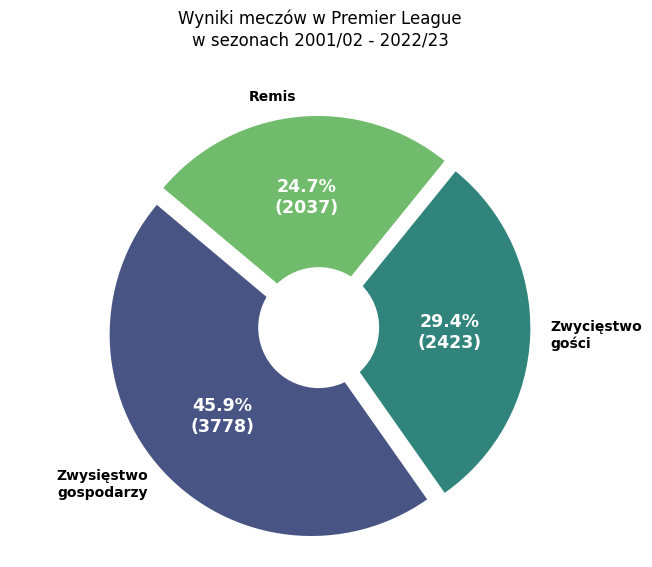

In [13]:
colors = ['#485484', '#30847c', '#70bc6c']

custom_labels = ['Zwysięstwo\ngospodarzy', 'Zwycięstwo\ngości', 'Remis']
explode = (0.05, 0.05, 0.05)

def func(pct, allvalues):
    absolute = int(np.ceil(pct / 100. * np.sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 6))
ftr_counts = df['FTR'].value_counts()
wedges, texts, autotexts = plt.pie(ftr_counts, explode=explode, labels=custom_labels, autopct=lambda pct: func(pct, ftr_counts), 
                                    startangle=140, colors=colors)
plt.title('Wyniki meczów w Premier League\nw sezonach 2001/02 - 2022/23\n\n')
plt.gca().add_artist(plt.Circle((0,0),0.3,fc='white'))
plt.axis('equal')

for autotext in autotexts:
    autotext.set_color('white')  
    autotext.set_weight('bold')
    autotext.set_fontsize(12.5)
    
for text in texts:
    text.set_weight('bold')

plt.show()

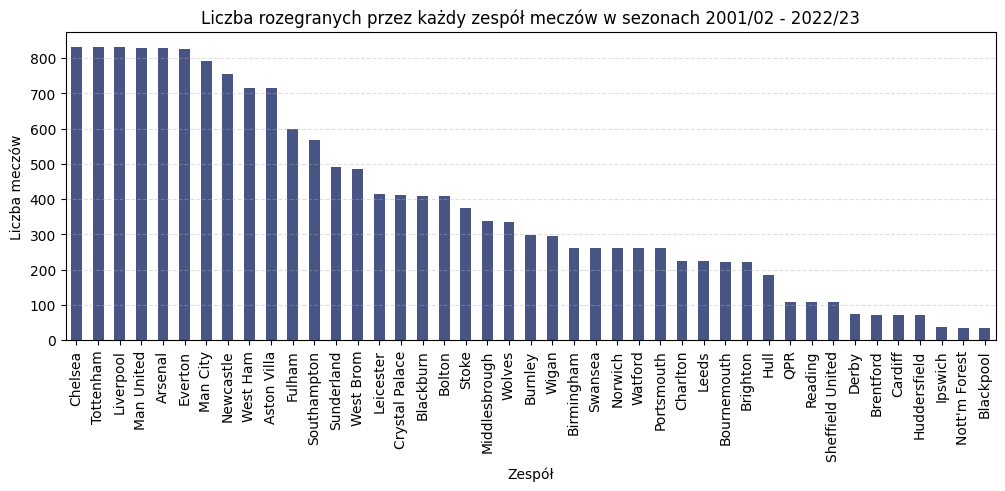

In [14]:
home_counts = df['home_team'].value_counts()
away_counts = df['away_team'].value_counts()

team_counts = home_counts.add(away_counts, fill_value=0)
team_counts_sorted = team_counts.sort_values(ascending=False)

team_counts_sorted.plot(kind='bar', figsize=(12, 4), color=colors[0])
plt.title('Liczba rozegranych przez każdy zespół meczów w sezonach 2001/02 - 2022/23')
plt.xlabel('Zespół')
plt.ylabel('Liczba meczów')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

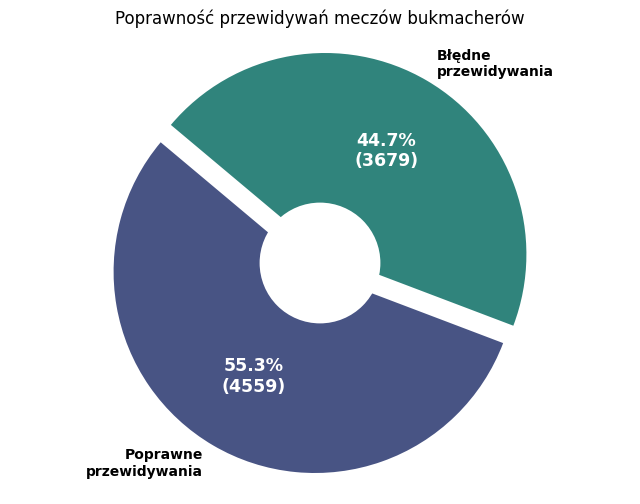

4481.909999999984


In [15]:
balance = 0
correct_predictions = 0

for index, row in df.iterrows():
    min_odds = min(row['OH'], row['OD'], row['OA'])
    if min_odds == row['OH'] and row['FTR'] == 'H':
        correct_predictions += 1
        balance += 1 * row['OH']
    elif min_odds == row['OD'] and row['FTR'] == 'D':
        correct_predictions += 1
        balance += 1 * row['OD']
    elif min_odds == row['OA'] and row['FTR'] == 'A':
        correct_predictions += 1
        balance += 1 * row['OA']
    else:
        balance -=1

incorrect_predictions = len(df) - correct_predictions

custom_labels = ['Poprawne\nprzewidywania', 'Błędne\nprzewidywania']
explode = (0.05, 0.05)

def func(pct, allvalues):
    absolute = int(np.ceil(pct / 100. * np.sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie([correct_predictions, incorrect_predictions], explode=explode, labels=custom_labels, 
                                    autopct=lambda pct: func(pct, [correct_predictions, incorrect_predictions]), 
                                    startangle=140, colors=colors)
plt.title('Poprawność przewidywań meczów bukmacherów')

plt.gca().add_artist(plt.Circle((0,0),0.3,fc='white'))
plt.axis('equal')

for autotext in autotexts:
    autotext.set_color('white')  
    autotext.set_weight('bold')
    autotext.set_fontsize(12.5)
    
for text in texts:
    text.set_weight('bold')

plt.show()
print(balance)

In [16]:
df['home_team_code'] = df['home_team'].astype('category').cat.codes
df['away_team_code'] = df['away_team'].astype('category').cat.codes

team_names = {
    code: name for code, name in zip(df['home_team_code'], df['home_team'])
}
team_names.update({
    code: name for code, name in zip(df['away_team_code'], df['away_team'])
})

sorted_team_names = dict(sorted(team_names.items(), key=lambda item: item[0]))
sorted_team_names

{0: 'Arsenal',
 1: 'Aston Villa',
 2: 'Birmingham',
 3: 'Blackburn',
 4: 'Blackpool',
 5: 'Bolton',
 6: 'Bournemouth',
 7: 'Brentford',
 8: 'Brighton',
 9: 'Burnley',
 10: 'Cardiff',
 11: 'Charlton',
 12: 'Chelsea',
 13: 'Crystal Palace',
 14: 'Derby',
 15: 'Everton',
 16: 'Fulham',
 17: 'Huddersfield',
 18: 'Hull',
 19: 'Ipswich',
 20: 'Leeds',
 21: 'Leicester',
 22: 'Liverpool',
 23: 'Man City',
 24: 'Man United',
 25: 'Middlesbrough',
 26: 'Newcastle',
 27: 'Norwich',
 28: "Nott'm Forest",
 29: 'Portsmouth',
 30: 'QPR',
 31: 'Reading',
 32: 'Sheffield United',
 33: 'Southampton',
 34: 'Stoke',
 35: 'Sunderland',
 36: 'Swansea',
 37: 'Tottenham',
 38: 'Watford',
 39: 'West Brom',
 40: 'West Ham',
 41: 'Wigan',
 42: 'Wolves'}

In [17]:
cols = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
for col in cols:
    df[f'{col}_difference'] = df[f'home_team_{col}_rolling'] - df[f'away_team_{col}_rolling']
    
df['LSP_difference'] = df[f'home_team_LSP'] - df[f'away_team_LSP']
    
df['target'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 2})

df.head()

season       date      home_team    away_team  FTHG  FTAG FTR  HTHG  \
380    2001 2001-08-18       Charlton      Everton     1     2   A     0   
382    2001 2001-08-18          Leeds  Southampton     2     0   H     0   
384    2001 2001-08-18      Liverpool     West Ham     2     1   H     1   
385    2001 2001-08-18  Middlesbrough      Arsenal     0     4   A     0   
386    2001 2001-08-18     Sunderland      Ipswich     1     0   H     1   

     HTAG HTR  ...  GS_difference  GC_difference  S_difference  OS_difference  \
380     0   D  ...            0.0           -0.2          -0.8            3.8   
382     0   D  ...            1.6           -0.8           3.0            0.8   
384     1   D  ...            1.6           -1.0           0.2           -4.2   
385     1   A  ...           -0.6            0.0           4.6            4.0   
386     0   H  ...           -0.2            0.2          -2.8            6.2   

     ST_difference  OST_difference  C_difference  OC_difference  \
380            0.4             2.6           1.4            3.4   
382            3.6             0.0           2.2            2.2   
384            0.6            -2.4          -1.4            0.8   
385            0.0             2.0          -3.0            3.4   
386            0.4             3.0          -3.2            4.0   

     LSP_difference  target  
380              -7       2  
382              -6       0  
384             -12       0  
385              12       2  
386               2       0  

[5 rows x 58 columns]

In [187]:
train = df[(df['season'] >= 2001) & (df['season'] <= 2020)]

train

season       date         home_team       away_team  FTHG  FTAG FTR  \
380     2001 2001-08-18          Charlton         Everton     1     2   A   
382     2001 2001-08-18             Leeds     Southampton     2     0   H   
384     2001 2001-08-18         Liverpool        West Ham     2     1   H   
385     2001 2001-08-18     Middlesbrough         Arsenal     0     4   A   
386     2001 2001-08-18        Sunderland         Ipswich     1     0   H   
...      ...        ...               ...             ...   ...   ...  ..   
7975    2020 2021-05-23         Leicester       Tottenham     2     4   A   
7976    2020 2021-05-23         Liverpool  Crystal Palace     2     0   H   
7977    2020 2021-05-23          Man City         Everton     5     0   H   
7978    2020 2021-05-23  Sheffield United         Burnley     1     0   H   
7979    2020 2021-05-23          West Ham     Southampton     3     0   H   

      HTHG  HTAG HTR  ...  GS_difference  GC_difference  S_difference  \
380      0     0   D  ...            0.0           -0.2          -0.8   
382      0     0   D  ...            1.6           -0.8           3.0   
384      1     1   D  ...            1.6           -1.0           0.2   
385      0     1   A  ...           -0.6            0.0           4.6   
386      1     0   H  ...           -0.2            0.2          -2.8   
...    ...   ...  ..  ...            ...            ...           ...   
7975     1     1   D  ...           -0.4            0.6           0.6   
7976     1     0   H  ...            1.0           -1.2           4.6   
7977     2     0   H  ...            1.6            1.2           0.4   
7978     1     0   H  ...           -1.0           -0.4          -3.8   
7979     2     0   H  ...           -0.2           -0.4           3.8   

      OS_difference  ST_difference  OST_difference  C_difference  \
380             3.8            0.4             2.6           1.4   
382             0.8            3.6             0.0           2.2   
384            -4.2            0.6            -2.4          -1.4   
385             4.0            0.0             2.0          -3.0   
386             6.2            0.4             3.0          -3.2   
...             ...            ...             ...           ...   
7975           -5.0           -1.0            -0.4           0.8   
7976           -1.6            0.4             0.6           0.8   
7977            0.6           -0.2             2.0           0.6   
7978           -0.2           -3.0             3.2          -1.4   
7979           -3.0           -1.4            -2.2          -0.4   

      OC_difference  LSP_difference  target  
380             3.4              -7       2  
382             2.2              -6       0  
384             0.8             -12       0  
385             3.4              12       2  
386             4.0               2       0  
...             ...             ...     ...  
7975           -2.0              -1       2  
7976           -1.8             -13       0  
7977           -4.4             -10       0  
7978            2.0              -1       0  
7979           -2.8               5       0  

[7488 rows x 58 columns]

In [188]:
test = df[df['season'] == 2021]

test

season       date  home_team    away_team  FTHG  FTAG FTR  HTHG  HTAG  \
7981    2021 2021-08-14  Leicester       Wolves     1     0   H     1     0   
7982    2021 2021-08-14    Norwich    Liverpool     0     3   A     0     1   
7983    2021 2021-08-14    Everton  Southampton     3     1   H     0     1   
7984    2021 2021-08-14    Watford  Aston Villa     3     2   H     2     0   
7985    2021 2021-08-14    Burnley     Brighton     1     2   A     1     0   
...      ...        ...        ...          ...   ...   ...  ..   ...   ...   
8355    2021 2022-05-22    Burnley    Newcastle     1     2   A     0     1   
8356    2021 2022-05-22    Arsenal      Everton     5     1   H     2     1   
8357    2021 2022-05-22    Chelsea      Watford     2     1   H     1     0   
8358    2021 2022-05-22   Brighton     West Ham     3     1   H     0     1   
8359    2021 2022-05-22  Brentford        Leeds     1     2   A     0     0   

     HTR  ...  GS_difference  GC_difference  S_difference  OS_difference  \
7981   H  ...            0.8            1.0           0.6           -2.2   
7982   A  ...           -2.4            2.2         -12.0            9.8   
7983   A  ...           -0.8           -0.6          -1.8            0.0   
7984   H  ...            0.0            0.8          -1.6           -4.0   
7985   H  ...           -0.8            0.6           0.4            5.0   
...   ..  ...            ...            ...           ...            ...   
8355   A  ...           -0.2            0.0           2.0            1.4   
8356   H  ...           -0.2            0.4           1.6           -1.4   
8357   H  ...            0.8           -1.6          10.2           -9.2   
8358   A  ...            0.4            0.0           1.2           -1.4   
8359   D  ...            1.2           -0.8           7.2           -4.8   

      ST_difference  OST_difference  C_difference  OC_difference  \
7981            0.8            -1.6          -0.2           -1.4   
7982           -3.4             3.0          -7.0            1.8   
7983           -1.2            -1.6           0.2            1.8   
7984           -0.2            -1.0          -2.2            0.2   
7985            0.4            -0.2           2.4           -0.2   
...             ...             ...           ...            ...   
8355            0.6             0.8           0.4            1.6   
8356            1.0            -1.2           0.0            0.8   
8357            3.8            -4.2           3.0           -6.4   
8358            1.4            -0.4          -1.0            0.4   
8359            2.4            -2.8           2.8            0.6   

      LSP_difference  target  
7981              -8       0  
7982              18       2  
7983              -5       0  
7984              10       0  
7985               1       2  
...              ...     ...  
8355               5       2  
8356              -2       0  
8357             -17       0  
8358              10       0  
8359              12       2  

[375 rows x 58 columns]

In [20]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'home_team_LSP',
    'away_team_LSP',
    'home_team_GS_rolling',
    'away_team_GS_rolling',
    'home_team_GC_rolling',
    'away_team_GC_rolling',
    'home_team_S_rolling', 
    'away_team_S_rolling', 
    'home_team_OS_rolling',
    'away_team_OS_rolling', 
    'home_team_ST_rolling', 
    'away_team_ST_rolling', 
    'home_team_OST_rolling', 
    'away_team_OST_rolling', 
    'home_team_C_rolling', 
    'away_team_C_rolling', 
    'home_team_OC_rolling', 
    'away_team_OC_rolling',
    'home_team_points_rolling',
    'away_team_points_rolling',
    'LSP_difference',
    'points_difference', 
    'GS_difference', 
    'GC_difference', 
    'S_difference', 
    'OS_difference', 
    'ST_difference', 
    'OST_difference', 
    'C_difference', 
    'OC_difference',
    'OH',
    'OD',
    'OA'
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

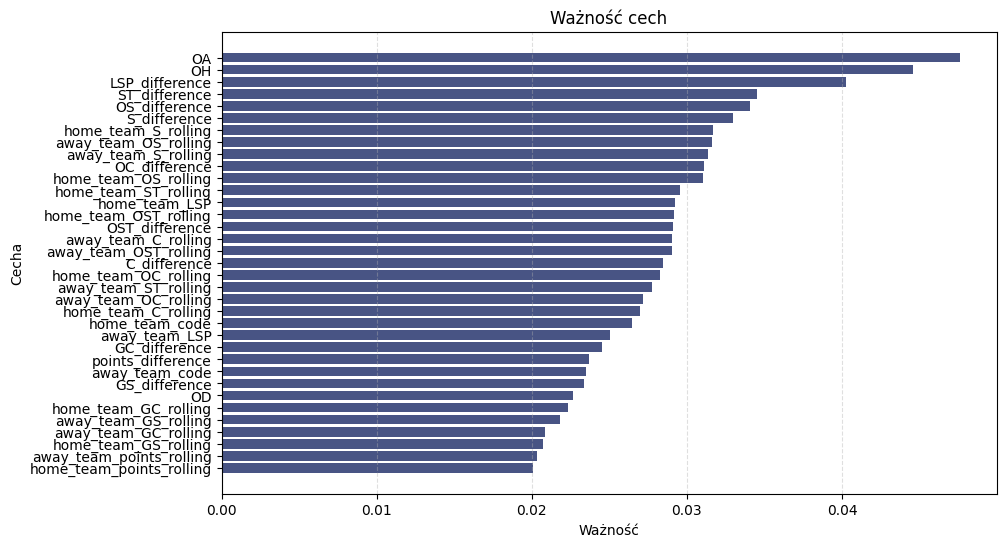

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors[0])
plt.xlabel('Ważność')
plt.ylabel('Cecha')
plt.title('Ważność cech')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.xlim(0)
plt.show()

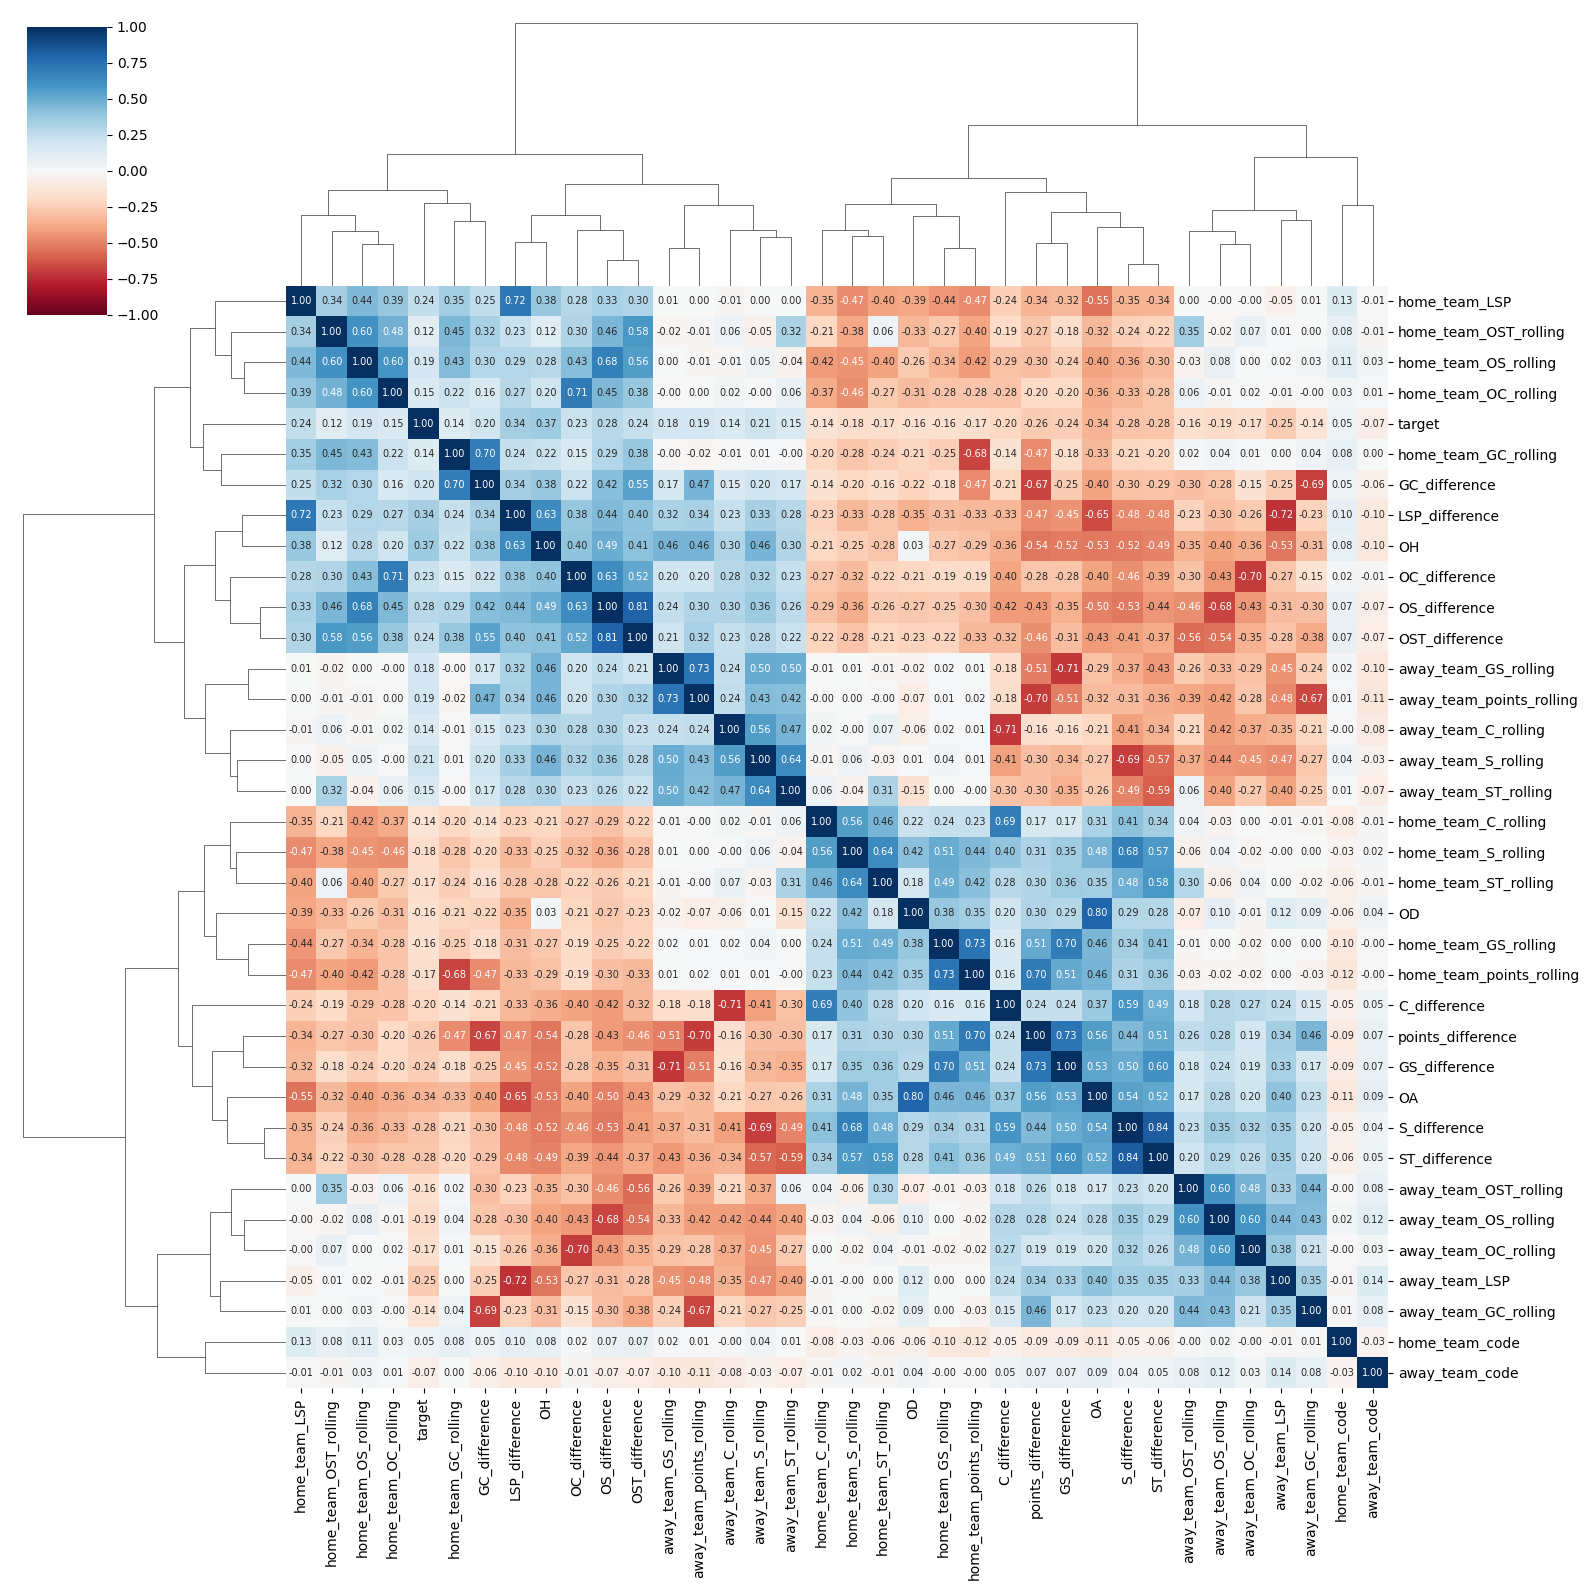

In [22]:
corr_matrix = df[predictors + ['target']].corr()

sns.clustermap(corr_matrix, method='complete', annot=True, cmap='RdBu', 
               fmt=".2f", annot_kws={"fontsize": 7}, vmin=-1, vmax=1, figsize=(16, 16))

In [189]:
predictors = [
    'home_team_code',
    'away_team_code',
    'home_team_LSP',
    'away_team_LSP',
    'GS_difference',
    'GC_difference',
    'ST_difference',
    'OS_difference',
    'OA',
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [24]:
X_train

home_team_code  away_team_code  home_team_LSP  away_team_LSP  \
3800               1              40              6             17   
3801               3              15             10              8   
3802               5              16             14             12   
3803              12              39              1             21   
3804              35               2             13              9   
...              ...             ...            ...            ...   
6075              26              37             15              5   
6076              15              27             11             21   
6077              12              21              1             14   
6078               0               1              3             17   
6079              24               6              4             21   

      GS_difference  GC_difference  ST_difference  OS_difference     OA  
3800           -0.2           -0.8            2.0            2.4   4.00  
3801           -0.4            0.0           -2.0            1.0   2.50  
3802            0.4           -0.6            2.8            5.8   3.00  
3803            2.6           -0.4            3.0           -4.2  14.00  
3804            0.0           -0.8           -0.6           -0.6   3.20  
...             ...            ...            ...            ...    ...  
6075           -0.8           -0.4           -1.4           -2.4   1.75  
6076            0.0            0.8           -0.6           11.0   4.00  
6077           -0.6            1.2           -0.2            2.0   3.30  
6078            0.2           -1.4            2.8           -3.2  14.00  
6079            0.2           -1.2            1.2           -2.2   4.50  

[2255 rows x 9 columns]

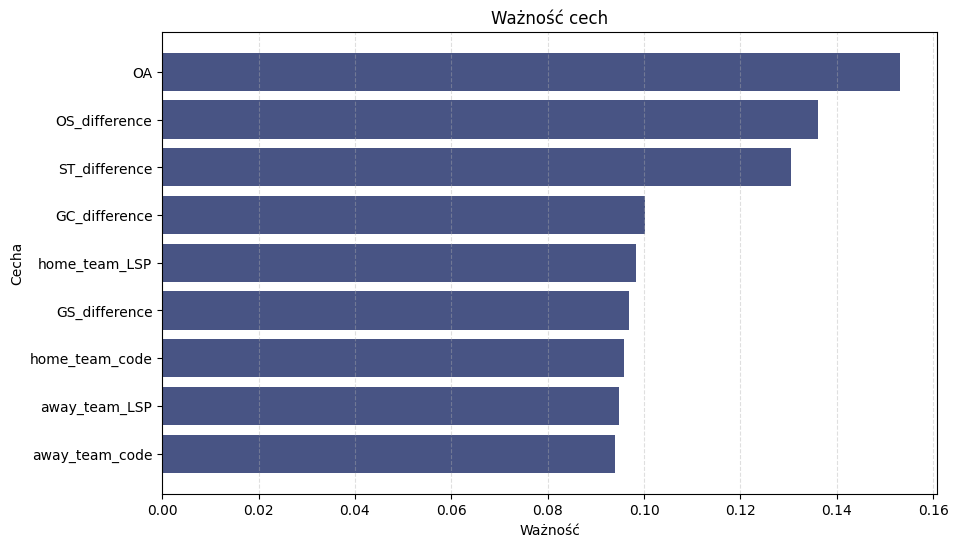

In [25]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors[0])
plt.xlabel('Ważność')
plt.ylabel('Cecha')
plt.title('Ważność cech')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.xlim(0)
plt.show()

Best accuracy: 0.61; n=99


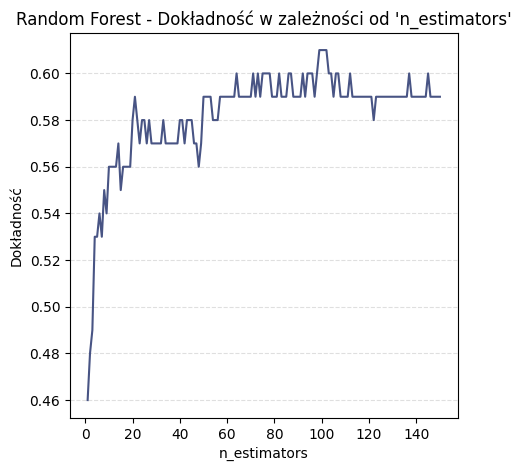

In [26]:
plot_scores_rf = []

for n_estimators in range(1, 151):
    clf_rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=10, random_state=1)
    clf_rf.fit(X_train,y_train)
    test_preds = clf_rf.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_rf.append(score)
 
plt.figure(figsize = (5, 5))
plt.plot(range(1, 151), plot_scores_rf, color=colors[0])
plt.title("Random Forest - Dokładność w zależności od 'n_estimators'")
plt.xlabel('n_estimators')
plt.ylabel('Dokładność')
plt.xticks(range(0, 151, 20))
plt.grid(axis='y', linestyle='--', alpha=0.4)

best_accuracy = max(plot_scores_rf)
best_n_rf = plot_scores_rf.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n_rf}')

In [27]:
rf = RandomForestClassifier(n_estimators=best_n_rf, min_samples_split=10 ,random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=99, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.64      0.81      0.71       187
                Remis       0.42      0.12      0.19        84
     Zwycięstwo gości       0.58      0.63      0.61       109

             accuracy                           0.61       380
            macro avg       0.54      0.52      0.50       380
         weighted avg       0.57      0.61      0.57       380



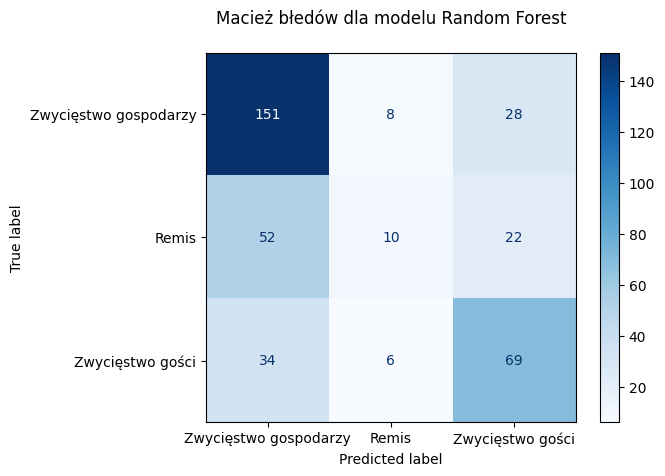

In [28]:
rf_test_preds = rf.predict(X_test)

report = classification_report(y_test, rf_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macież błedów dla modelu Random Forest\n')
plt.show()

In [29]:
rf_train_preds = rf.predict(X_train)

rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
print(f'Random Forest Train Accuracy: {rf_train_accuracy:.2f}')

Random Forest Train Accuracy: 0.92


***
Próba zbalansowania zbioru treningowego (oversampling)

In [30]:
class_counts = train['FTR'].value_counts()

print(class_counts)

FTR
H    1014
A     658
D     583
Name: count, dtype: Int64


In [31]:
class_counts = train['FTR'].value_counts()
majority_class = class_counts.idxmax()

balanced_train_over = pd.concat([
    resample(train[train['FTR'] == cls], 
             replace=True,
             n_samples=class_counts[majority_class],
             random_state=42)
    for cls in class_counts.index
])

print(balanced_train_over['FTR'].value_counts())

FTR
H    1014
A    1014
D    1014
Name: count, dtype: Int64


In [32]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [33]:
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=99, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.67      0.64      0.65       187
                Remis       0.26      0.18      0.21        84
     Zwycięstwo gości       0.51      0.67      0.58       109

             accuracy                           0.55       380
            macro avg       0.48      0.50      0.48       380
         weighted avg       0.53      0.55      0.54       380



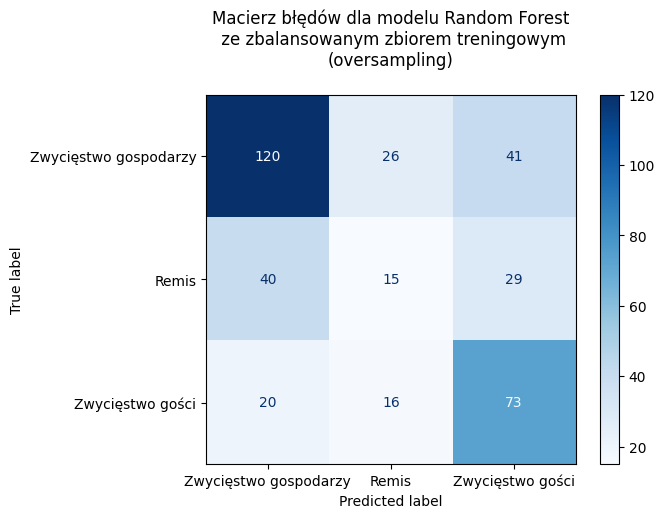

In [34]:
rf2_test_preds = rf.predict(X_test)

report = classification_report(y_test, rf2_test_preds,
                              target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Random Forest\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

***
Próba zbalansowanie zbioru treningowego (undersampling)

In [35]:
class_counts = train['FTR'].value_counts()
minority_class = class_counts.idxmin()

balanced_train_under = pd.concat([
    resample(train[train['FTR'] == cls], 
             replace=False,
             n_samples=class_counts[minority_class],
             random_state=42)
    for cls in class_counts.index
])

print(balanced_train_under['FTR'].value_counts())


FTR
H    583
A    583
D    583
Name: count, dtype: Int64


In [36]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [37]:
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=99, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.67      0.56      0.61       187
                Remis       0.28      0.35      0.31        84
     Zwycięstwo gości       0.57      0.62      0.59       109

             accuracy                           0.53       380
            macro avg       0.50      0.51      0.50       380
         weighted avg       0.55      0.53      0.54       380



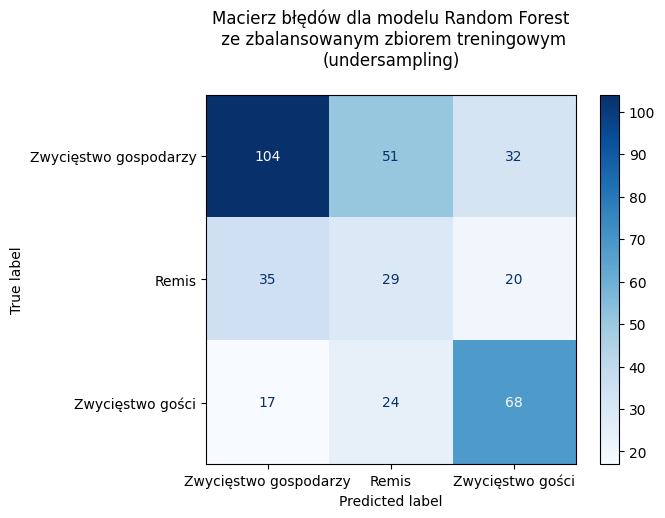

In [38]:
rf3_test_preds = rf.predict(X_test)

report = classification_report(y_test, rf3_test_preds,
                              target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Random Forest\n ze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [39]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.59; n=68


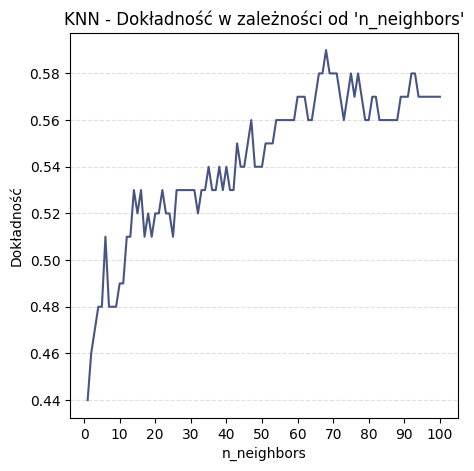

In [40]:
plot_scores_knn = []

for n_neighbors in range(1, 101):
    clf_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf_knn.fit(X_train,y_train)
    test_preds = clf_knn.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_knn.append(score)
 
plt.figure(figsize = (5, 5))
plt.plot(range(1, 101),plot_scores_knn, color=colors[0])
plt.title("KNN - Dokładność w zależności od 'n_neighbors'")
plt.xlabel('n_neighbors')
plt.ylabel('Dokładność')
plt.xticks(range(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.4)

best_accuracy = max(plot_scores_knn)
best_n_knn = plot_scores_knn.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n_knn}')

In [41]:
knn = KNeighborsClassifier(n_neighbors=best_n_knn)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=68)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.63      0.83      0.71       187
                Remis       0.24      0.05      0.08        84
     Zwycięstwo gości       0.55      0.59      0.57       109

             accuracy                           0.59       380
            macro avg       0.47      0.49      0.45       380
         weighted avg       0.52      0.59      0.53       380



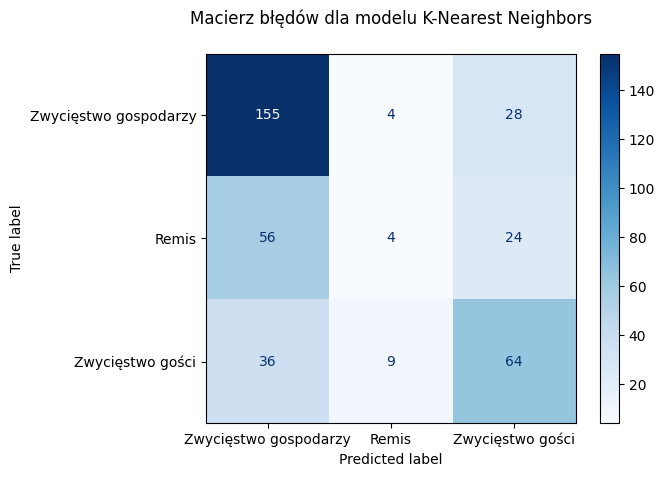

In [42]:
knn_test_preds = knn.predict(X_test)

report = classification_report(y_test, knn_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości']
)

print(report)

conf_matrix = confusion_matrix(y_test, knn_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu K-Nearest Neighbors\n')
plt.show()

In [43]:
knn_train_preds = knn.predict(X_train)

knn_train_accuracy = accuracy_score(y_train, knn_train_preds)
print(f'KNN Train accuracy: {knn_train_accuracy:.2f}')

KNN Train accuracy: 0.53


***
Próba wykorzystania zbalansowanego zbioru treningowego

In [44]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [45]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=68)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.67      0.51      0.58       187
                Remis       0.23      0.27      0.25        84
     Zwycięstwo gości       0.44      0.55      0.49       109

             accuracy                           0.47       380
            macro avg       0.45      0.45      0.44       380
         weighted avg       0.51      0.47      0.48       380



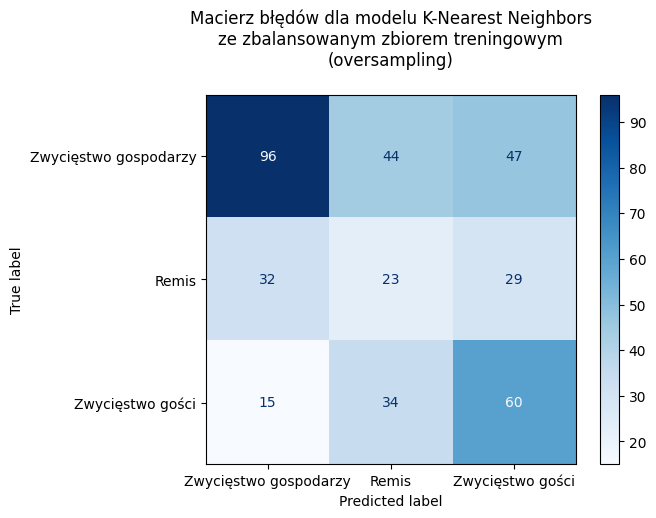

In [46]:
knn2_test_preds = knn.predict(X_test)

report = classification_report(y_test, knn2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, knn2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu K-Nearest Neighbors\nze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [47]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [48]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=68)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.67      0.48      0.56       187
                Remis       0.21      0.29      0.24        84
     Zwycięstwo gości       0.49      0.58      0.53       109

             accuracy                           0.47       380
            macro avg       0.45      0.45      0.44       380
         weighted avg       0.51      0.47      0.48       380



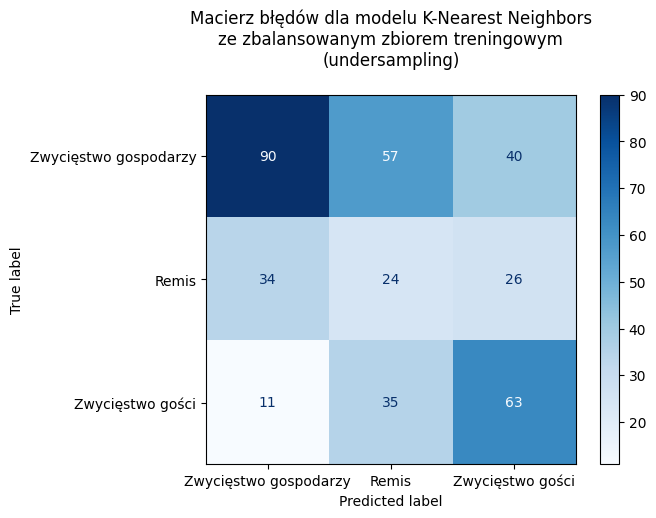

In [49]:
knn3_test_preds = knn.predict(X_test)

report = classification_report(y_test, knn3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, knn3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu K-Nearest Neighbors\nze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [50]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.59; c=0.01


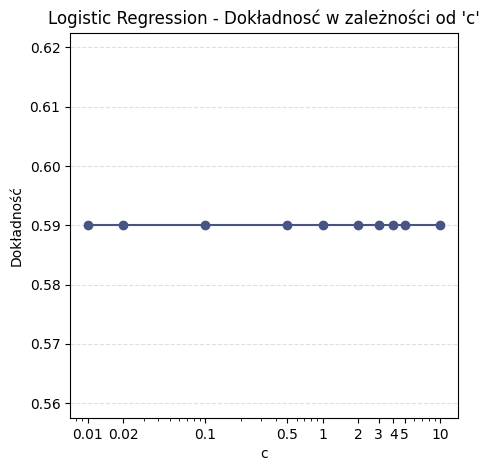

In [51]:
plot_scores_lr = []

cs = [0.01, 0.02, 0.1, 0.5, 1, 2, 3, 4, 5, 10]

for c in cs:
    lr = LogisticRegression(C=c, solver='lbfgs', multi_class='multinomial', max_iter=1000, random_state=1)
    lr.fit(X_train, y_train)
    test_preds = lr.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_lr.append(score)
 
plt.figure(figsize=(5, 5))
plt.plot(cs, plot_scores_lr, marker='o', color=colors[0])
plt.title("Logistic Regression - Dokładnosć w zależności od 'c'")
plt.xlabel("c")
plt.ylabel('Dokładność')
plt.xscale('log')
plt.xticks(cs, cs)
plt.grid(axis='y', linestyle='--', alpha=0.4)

best_accuracy = max(plot_scores_lr)
best_c_lr = cs[plot_scores_lr.index(best_accuracy)]
print(f'Best accuracy: {best_accuracy}; c={best_c_lr}')

In [52]:
lr = LogisticRegression(C=best_c_lr, solver='lbfgs', multi_class='multinomial', 
                        max_iter=1000, random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial',
                   random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.62      0.82      0.70       187
                Remis       0.00      0.00      0.00        84
     Zwycięstwo gości       0.54      0.65      0.59       109

             accuracy                           0.59       380
            macro avg       0.39      0.49      0.43       380
         weighted avg       0.46      0.59      0.52       380



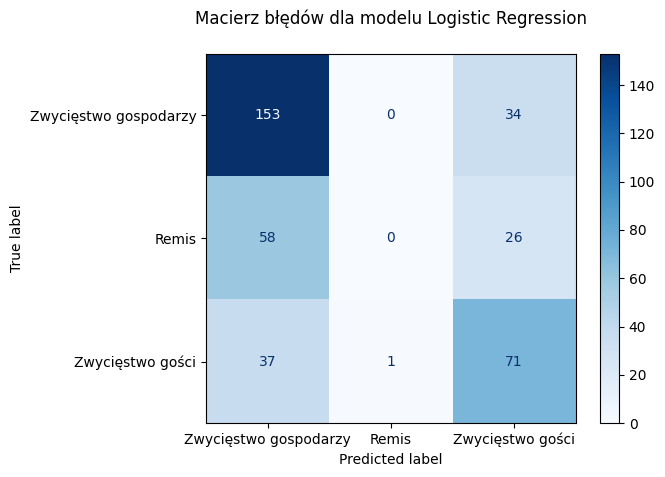

In [53]:
lr_test_preds = lr.predict(X_test)

report = classification_report(y_test, lr_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, lr_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Logistic Regression\n')
plt.show()

In [54]:
lr_train_preds = lr.predict(X_train)

lr_train_accuracy = accuracy_score(y_train, lr_train_preds)
print(f'Logistic Regression Train accuracy: {lr_train_accuracy:.2f}')

Logistic Regression Train accuracy: 0.52


***
Próba wykorzystania zbalansowanego zbioru treningowego

In [55]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [56]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial',
                   random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.69      0.52      0.60       187
                Remis       0.27      0.29      0.28        84
     Zwycięstwo gości       0.52      0.71      0.60       109

             accuracy                           0.52       380
            macro avg       0.49      0.51      0.49       380
         weighted avg       0.55      0.52      0.53       380



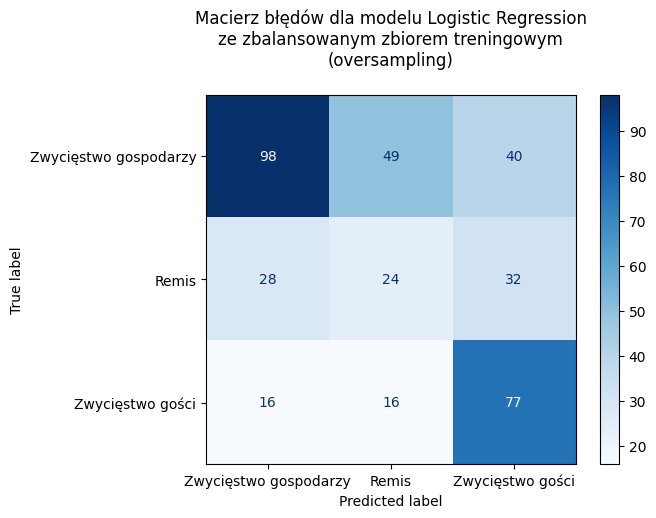

In [57]:
lr2_test_preds = lr.predict(X_test)

report = classification_report(y_test, lr2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, lr2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Logistic Regression\nze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [58]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [59]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial',
                   random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.67      0.52      0.59       187
                Remis       0.26      0.27      0.27        84
     Zwycięstwo gości       0.51      0.69      0.59       109

             accuracy                           0.52       380
            macro avg       0.48      0.50      0.48       380
         weighted avg       0.54      0.52      0.52       380



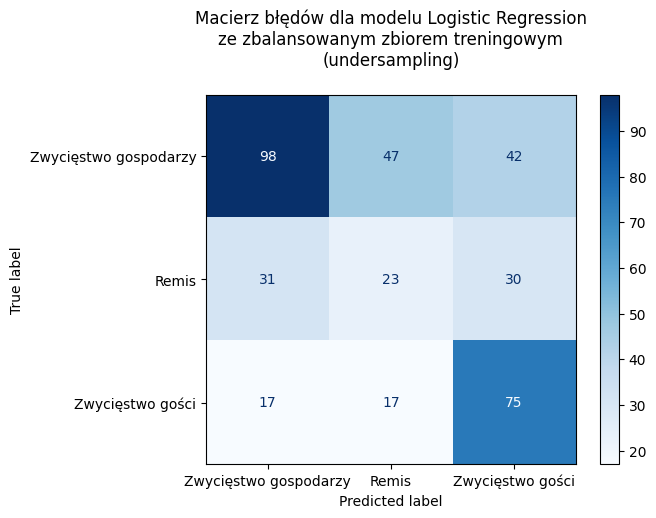

In [60]:
lr3_test_preds = lr.predict(X_test)

report = classification_report(y_test, lr3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, lr3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Logistic Regression\nze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [61]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.61; n=4


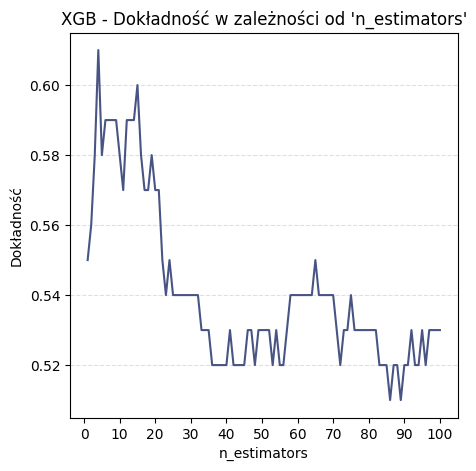

In [62]:
plot_scores_xgb = []

for n in range(1, 101):
    xgb = XGBClassifier(n_estimators=n, min_samples_split=10, random_state=1)
    xgb.fit(X_train,y_train)
    test_preds = xgb.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_xgb.append(score)
 
plt.figure(figsize = (5, 5))
plt.plot(range(1, 101), plot_scores_xgb, color=colors[0])
plt.title("XGB - Dokładność w zależności od 'n_estimators'")
plt.xlabel('n_estimators')
plt.ylabel('Dokładność')
plt.xticks(range(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.4)

best_accuracy = max(plot_scores_xgb)
best_n_xgb = plot_scores_xgb.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n_xgb}')

In [63]:
xgb = XGBClassifier(n_estimators=best_n_xgb, min_samples_split=10, random_state=1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.65      0.79      0.71       187
                Remis       0.37      0.17      0.23        84
     Zwycięstwo gości       0.60      0.63      0.62       109

             accuracy                           0.61       380
            macro avg       0.54      0.53      0.52       380
         weighted avg       0.57      0.61      0.58       380



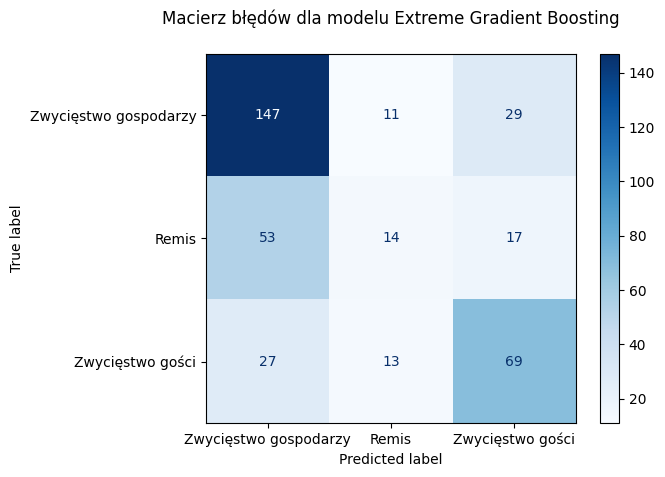

In [64]:
xgb_test_preds = xgb.predict(X_test)

report = classification_report(y_test, xgb_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Extreme Gradient Boosting\n')
plt.show()

In [65]:
xgb_train_preds = xgb.predict(X_train)

xgb_train_accuracy = accuracy_score(y_train, xgb_train_preds)
print(f'XGB Train accuracy: {xgb_train_accuracy:.2f}')

XGB Train accuracy: 0.67


***
Próba zastosowania zbalansowanego zbioru treningowego

In [161]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [162]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.69      0.60      0.64       187
                Remis       0.31      0.35      0.32        84
     Zwycięstwo gości       0.53      0.60      0.56       109

             accuracy                           0.54       380
            macro avg       0.51      0.51      0.51       380
         weighted avg       0.56      0.54      0.55       380



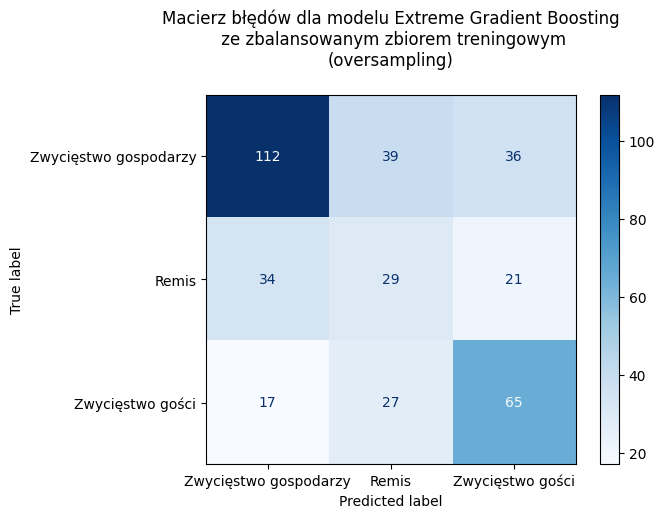

In [163]:
xgb2_test_preds = xgb.predict(X_test)

report = classification_report(y_test, xgb2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Extreme Gradient Boosting\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [164]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [165]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.65      0.49      0.56       187
                Remis       0.26      0.35      0.29        84
     Zwycięstwo gości       0.58      0.67      0.62       109

             accuracy                           0.51       380
            macro avg       0.50      0.50      0.49       380
         weighted avg       0.54      0.51      0.52       380



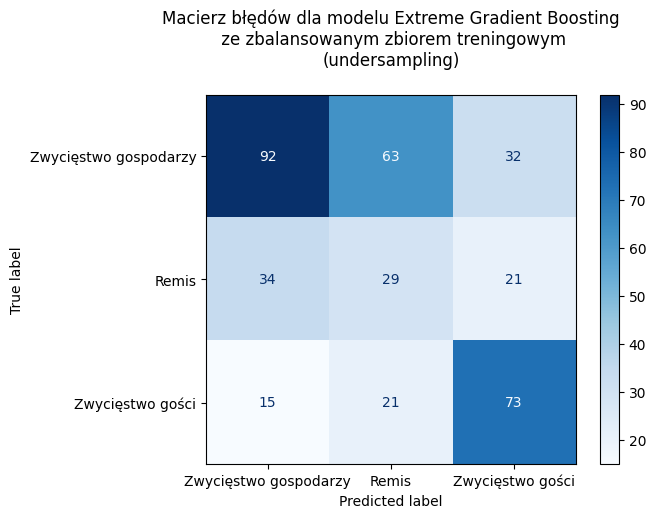

In [166]:
xgb3_test_preds = xgb.predict(X_test)

report = classification_report(y_test, xgb3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Extreme Gradient Boosting\n ze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [72]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.59; c=5


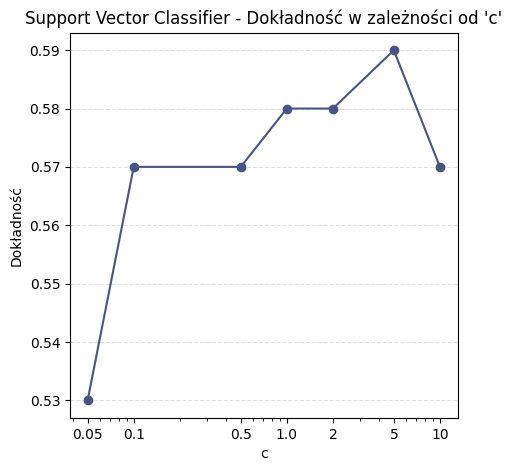

In [73]:
plot_scores_svc = []

cs = [0.05, 0.1, 0.5, 1.0, 2, 5, 10]

for c in cs:
    svc = SVC(kernel='rbf', C=c, random_state=1)
    svc.fit(X_train, y_train)
    test_preds = svc.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_svc.append(score)
 
plt.figure(figsize=(5, 5))
plt.plot(cs, plot_scores_svc, marker='o', color=colors[0])
plt.title("Support Vector Classifier - Dokładność w zależności od 'c'")
plt.xlabel("c")
plt.ylabel("Dokładność")
plt.xscale('log') 
plt.xticks(cs, cs)
plt.grid(axis='y', linestyle='--', alpha=0.4)

best_accuracy = max(plot_scores_svc)
best_c_svc = cs[plot_scores_svc.index(best_accuracy)]
print(f'Best accuracy: {best_accuracy}; c={best_c_svc}')

In [74]:
svc = SVC(kernel='rbf', C=best_c_svc, random_state=1)
svc.fit(X_train, y_train)

SVC(C=5, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.59      0.86      0.70       187
                Remis       0.00      0.00      0.00        84
     Zwycięstwo gości       0.59      0.58      0.58       109

             accuracy                           0.59       380
            macro avg       0.39      0.48      0.43       380
         weighted avg       0.46      0.59      0.51       380



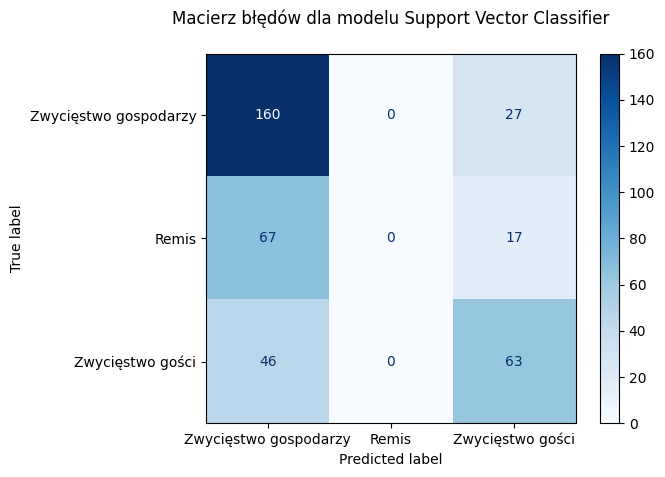

In [75]:
svc_test_preds = svc.predict(X_test)

report = classification_report(y_test, svc_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, svc_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Support Vector Classifier\n')
plt.show()

In [76]:
svc_train_preds = svc.predict(X_train)

svc_train_accuracy = accuracy_score(y_train, svc_train_preds)
print(f'SVM Train accuracy: {svc_train_accuracy:.2f}')

SVM Train accuracy: 0.53


***
Proba zastosowania zbalansowangeo zbioru treningowego

In [179]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [180]:
svc.fit(X_train, y_train)

SVC(C=5, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.70      0.53      0.61       187
                Remis       0.26      0.29      0.27        84
     Zwycięstwo gości       0.48      0.62      0.54       109

             accuracy                           0.51       380
            macro avg       0.48      0.48      0.47       380
         weighted avg       0.54      0.51      0.51       380



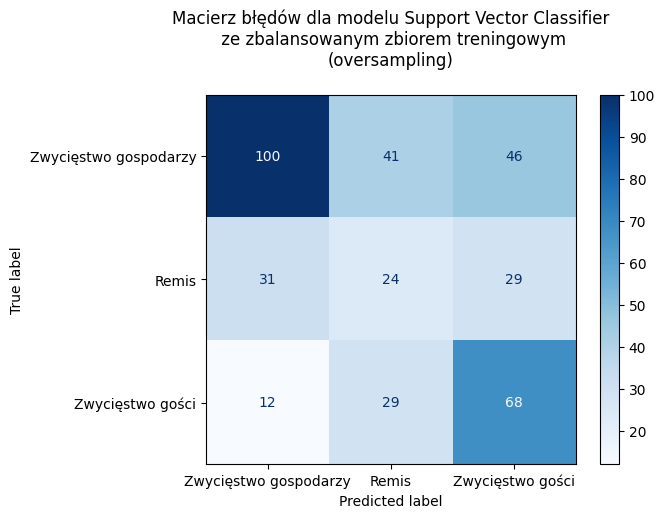

In [181]:
svc2_test_preds = svc.predict(X_test)

report = classification_report(y_test, svc2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, svc2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Support Vector Classifier\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [176]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [177]:
svc.fit(X_train, y_train)

SVC(C=5, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.67      0.55      0.60       187
                Remis       0.26      0.27      0.27        84
     Zwycięstwo gości       0.51      0.64      0.57       109

             accuracy                           0.51       380
            macro avg       0.48      0.49      0.48       380
         weighted avg       0.53      0.51      0.52       380



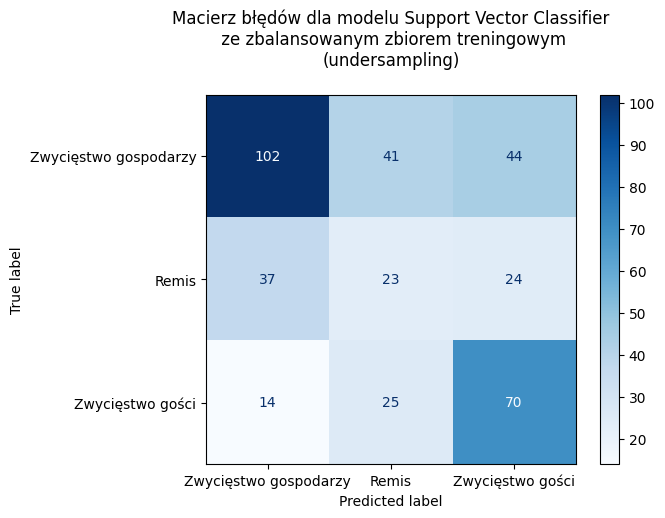

In [178]:
svc3_test_preds = svc.predict(X_test)

report = classification_report(y_test, svc3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, svc3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Support Vector Classifier\n ze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [190]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [191]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [192]:
nn = Sequential()
nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(3, activation='softmax'))

In [193]:
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [194]:
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
188/188 [==============================] - 1s 2ms/step - loss: 0.9954 - accuracy: 0.5177 - val_loss: 0.9653 - val_accuracy: 0.5434
Epoch 2/50
188/188 [==============================] - 0s 1ms/step - loss: 0.9777 - accuracy: 0.5324 - val_loss: 0.9686 - val_accuracy: 0.5454
Epoch 3/50
188/188 [==============================] - 0s 1ms/step - loss: 0.9717 - accuracy: 0.5329 - val_loss: 0.9671 - val_accuracy: 0.5414
Epoch 4/50
188/188 [==============================] - 0s 1ms/step - loss: 0.9688 - accuracy: 0.5381 - val_loss: 0.9657 - val_accuracy: 0.5427
Epoch 5/50
188/188 [==============================] - 0s 1ms/step - loss: 0.9648 - accuracy: 0.5382 - val_loss: 0.9650 - val_accuracy: 0.5407
Epoch 6/50
188/188 [==============================] - 0s 1ms/step - loss: 0.9614 - accuracy: 0.5407 - val_loss: 0.9639 - val_accuracy: 0.5461
Epoch 7/50
188/188 [==============================] - 0s 2ms/step - loss: 0.9590 - accuracy: 0.5429 - val_loss: 0.9738 - val_accuracy: 0.5427
Epoch 

In [195]:
nn_test_preds = nn.predict(X_test)
nn_test_preds = np.argmax(nn_test_preds, axis=1)

12/12 [==============================] - 0s 1ms/step


                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.54      0.88      0.67       162
                Remis       0.09      0.01      0.02        86
     Zwycięstwo gości       0.60      0.49      0.54       127

             accuracy                           0.55       375
            macro avg       0.41      0.46      0.41       375
         weighted avg       0.46      0.55      0.48       375



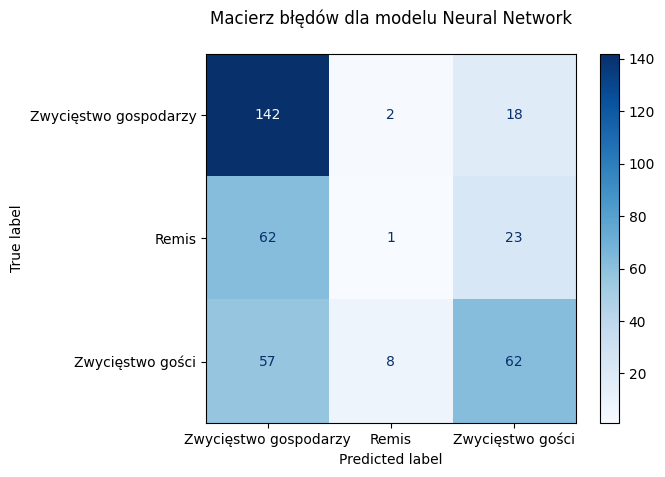

In [196]:
nn_report = classification_report(y_test, nn_test_preds, 
                                  target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(nn_report)

nn_conf_matrix = confusion_matrix(y_test, nn_test_preds, labels=[0, 1, 2])
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, 
                                 display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

nn_disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Neural Network\n')
plt.show()

In [90]:
nn_train_preds = nn.predict(X_train)
nn_train_preds = np.argmax(nn_train_preds, axis=1)

nn_train_accuracy = accuracy_score(y_train, nn_train_preds)
print(f'Neural Network Train accuracy: {nn_train_accuracy:.2f}')

71/71 [==============================] - 0s 869us/step
Neural Network Train accuracy: 0.60


***
Próba zastosowania zbalansowanego zbioru treningowego

In [91]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [92]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [93]:
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7995 - accuracy: 0.6572 - val_loss: 1.2408 - val_accuracy: 0.2775
Epoch 2/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7742 - accuracy: 0.6782 - val_loss: 1.6594 - val_accuracy: 0.0920
Epoch 3/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7643 - accuracy: 0.6737 - val_loss: 1.6582 - val_accuracy: 0.1067
Epoch 4/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7531 - accuracy: 0.6868 - val_loss: 1.6095 - val_accuracy: 0.1117
Epoch 5/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7373 - accuracy: 0.6790 - val_loss: 1.5519 - val_accuracy: 0.1199
Epoch 6/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7307 - accuracy: 0.6872 - val_loss: 1.5069 - val_accuracy: 0.1708
Epoch 7/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7171 - accuracy: 0.7004 - val_loss: 1.4994 - val_accuracy: 0.1954
Epoch 8/50
77/77 [==

In [94]:
nn2_test_preds = nn.predict(X_test)
nn2_test_preds = np.argmax(nn2_test_preds, axis=1)

12/12 [==============================] - 0s 909us/step


                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.66      0.68      0.67       187
                Remis       0.29      0.17      0.21        84
     Zwycięstwo gości       0.45      0.58      0.51       109

             accuracy                           0.54       380
            macro avg       0.47      0.47      0.46       380
         weighted avg       0.52      0.54      0.52       380



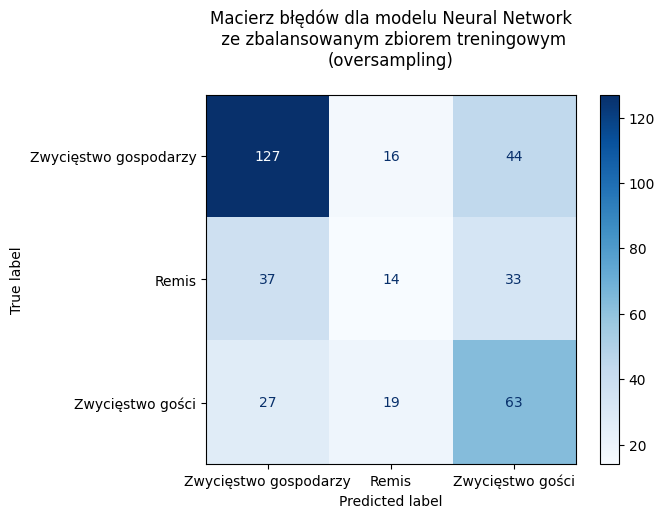

In [95]:
report = classification_report(y_test, nn2_test_preds, 
                                  target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

nn_conf_matrix = confusion_matrix(y_test, nn2_test_preds, labels=[0, 1, 2])
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, 
                                 display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

nn_disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Neural Network\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [96]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [97]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [98]:
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
44/44 [==============================] - 0s 3ms/step - loss: 0.8448 - accuracy: 0.6690 - val_loss: 1.2374 - val_accuracy: 0.4286
Epoch 2/50
44/44 [==============================] - 0s 2ms/step - loss: 0.8093 - accuracy: 0.6741 - val_loss: 1.2661 - val_accuracy: 0.4200
Epoch 3/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7702 - accuracy: 0.6812 - val_loss: 1.4647 - val_accuracy: 0.3114
Epoch 4/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7410 - accuracy: 0.6969 - val_loss: 1.3720 - val_accuracy: 0.3543
Epoch 5/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7344 - accuracy: 0.7069 - val_loss: 1.5184 - val_accuracy: 0.2857
Epoch 6/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7245 - accuracy: 0.7005 - val_loss: 1.5085 - val_accuracy: 0.2886
Epoch 7/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7026 - accuracy: 0.7091 - val_loss: 1.3270 - val_accuracy: 0.3714
Epoch 8/50
44/44 [==

In [99]:
nn3_test_preds = nn.predict(X_test)
nn3_test_preds = np.argmax(nn3_test_preds, axis=1)

12/12 [==============================] - 0s 1ms/step


                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.64      0.65      0.64       187
                Remis       0.31      0.13      0.18        84
     Zwycięstwo gości       0.44      0.62      0.51       109

             accuracy                           0.53       380
            macro avg       0.46      0.47      0.45       380
         weighted avg       0.51      0.53      0.50       380



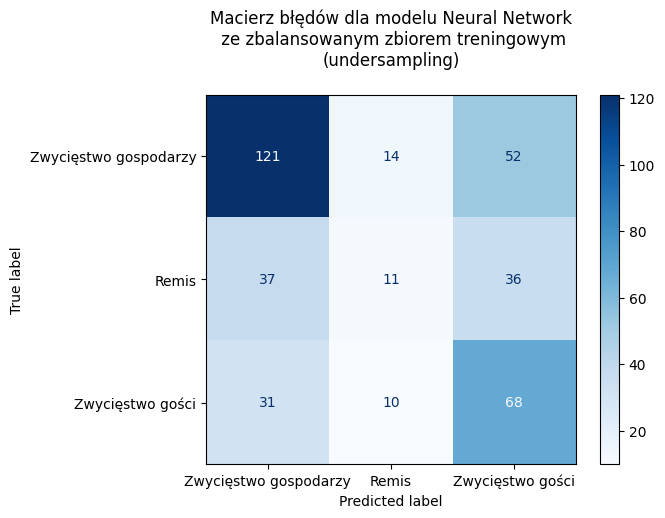

In [100]:
report = classification_report(y_test, nn3_test_preds, 
                                  target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

nn_conf_matrix = confusion_matrix(y_test, nn3_test_preds, labels=[0, 1, 2])
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, 
                                 display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

nn_disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Neural Network\n ze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [101]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [102]:
estimators = [('xgb', xgb), ('knn', knn)]

stacked = StackingClassifier(
    estimators=estimators,
    final_estimator=rf
)
                                   
stacked.fit(X_train, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              min_samples_split=10, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=4, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('knn', KNeighborsClassifier(n_neighbors=68))],
                   final_estimator=RandomForestClassifier(min_samples_split=10,
                                                          n_estimators=99,
                                                          random_state=1))

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.64      0.78      0.70       187
                Remis       0.31      0.17      0.22        84
     Zwycięstwo gości       0.56      0.56      0.56       109

             accuracy                           0.58       380
            macro avg       0.50      0.50      0.49       380
         weighted avg       0.55      0.58      0.55       380



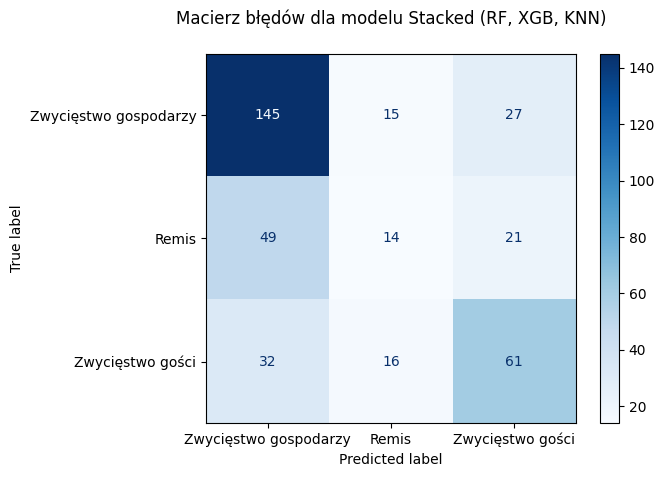

In [103]:
stacked_test_preds = stacked.predict(X_test)

report = classification_report(y_test, stacked_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, stacked_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Stacked (RF, XGB, KNN)\n')
plt.show()

In [104]:
sets = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

for i in range(1,11):
    training_sets = []
    test_sets = []
    
    for j in range(0,10):
        if i == 1:
            training_sets.append(df[(df['season'] == 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 2:
            training_sets.append(df[(df['season'] >= 2011+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 3:
            training_sets.append(df[(df['season'] >= 2010+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 4:
            training_sets.append(df[(df['season'] >= 2009+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 5:
            training_sets.append(df[(df['season'] >= 2008+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 6:
            training_sets.append(df[(df['season'] >= 2007+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 7:
            training_sets.append(df[(df['season'] >= 2006+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 8:
            training_sets.append(df[(df['season'] >= 2005+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 9:
            training_sets.append(df[(df['season'] >= 2004+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
        
        elif i == 10:
            training_sets.append(df[(df['season'] >= 2003+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])

    sets[f'trained_on_{i}_seasons'].append(training_sets)
    sets[f'trained_on_{i}_seasons'].append(test_sets)

In [105]:
models = [rf, knn, lr, xgb, svc, nn]

model_names = {
    'randomforestclassifier': 'Random Forest',
    'kneighborsclassifier': 'K-Nearest Neighbors',
    'logisticregression': 'Logistic Regression',
    'xgbclassifier': 'Extreme Gradient Boosting',
    'svc': 'Support Vector Classifier',
    'sequential': 'Neural Network',
}

accuracies_full = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

correct_predictions_by_team = {model_names[model] : defaultdict(int) for model in model_names}
number_of_predictions_by_team = defaultdict(int)

for key, value in sets.items():
    accuracies = {model_names[model.__class__.__name__.lower()]: [] for model in models}

    for model in models:
        
        i = int(re.findall(r'\d+', key)[0])
        
        print('^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v')
        print(f'Training {model_names[model.__class__.__name__.lower()]} model on {i} season/s\n')
        
        for train, test in zip(value[0], value[1]):

            X_train = train[predictors]
            y_train = train['target']
            
            X_test = test[predictors]
            y_test = test['target']
            
            print(f'Training season/s: {pd.concat([train["season"]]).unique().tolist()}')
            print(f'Test season: {pd.concat([test["season"]]).unique().tolist()}')
            
            if model == nn:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)

            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)

            accuracy = accuracy_score(y_test, preds)
            accuracies[model_names[model.__class__.__name__.lower()]].append(accuracy)
            
            if i >= 6:
            
                for pred_label, actual_label, home_team_code, away_team_code in zip(
                    preds, y_test, X_test['home_team_code'], X_test['away_team_code']
                ):
                    if pred_label == actual_label:
                        correct_predictions_by_team[
                            model_names[model.__class__.__name__.lower()]
                        ][team_names[home_team_code]] += 1

                        correct_predictions_by_team[
                            model_names[model.__class__.__name__.lower()]
                        ][team_names[away_team_code]] += 1

                    # zeby nie zliczac ilosci predykcji kilka razy
                    if model == rf:
                        number_of_predictions_by_team[team_names[home_team_code]] += 1
                        number_of_predictions_by_team[team_names[away_team_code]] += 1
                    
            
            print(f'Accuracy: {accuracy}\n')
            
    accuracies_full[key].append(accuracies)      

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.5173333333333333

Training season/s: [2013]
Test season: [2014]
Accuracy: 0.5078947368421053

Training season/s: [2014]
Test season: [2015]
Accuracy: 0.4666666666666667

Training season/s: [2015]
Test season: [2016]
Accuracy: 0.4868421052631579

Training season/s: [2016]
Test season: [2017]
Accuracy: 0.5459459459459459

Training season/s: [2017]
Test season: [2018]
Accuracy: 0.5552631578947368

Training season/s: [2018]
Test season: [2019]
Accuracy: 0.4868421052631579

Training season/s: [2019]
Test season: [2020]
Accuracy: 0.5

Training season/s: [2020]
Test season: [2021]
Accuracy: 0.5146666666666667

Training season/s: [2021]
Test season: [2022]
Accuracy: 0.5306666666666666

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.5306666666666666


Accuracy: 0.5173333333333333

Training season/s: [2020, 2021]
Test season: [2022]
Accuracy: 0.496

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Support Vector Classifier model on 2 season/s

Training season/s: [2011, 2012]
Test season: [2013]
Accuracy: 0.5546666666666666

Training season/s: [2012, 2013]
Test season: [2014]
Accuracy: 0.5184210526315789

Training season/s: [2013, 2014]
Test season: [2015]
Accuracy: 0.4613333333333333

Training season/s: [2014, 2015]
Test season: [2016]
Accuracy: 0.5605263157894737

Training season/s: [2015, 2016]
Test season: [2017]
Accuracy: 0.5486486486486486

Training season/s: [2016, 2017]
Test season: [2018]
Accuracy: 0.5684210526315789

Training season/s: [2017, 2018]
Test season: [2019]
Accuracy: 0.49736842105263157

Training season/s: [2018, 2019]
Test season: [2020]
Accuracy: 0.48947368421052634

Training season/s: [2019, 2020]
Test season: [2021]
Accuracy: 0.528

Training season/s: [2020, 2021]
Test season: [2022]
Accuracy: 0.528

^v^v^v

Accuracy: 0.5736842105263158

Training season/s: [2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5

Training season/s: [2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.48947368421052634

Training season/s: [2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.5493333333333333

Training season/s: [2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.528

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 4 season/s

Training season/s: [2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.52

Training season/s: [2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5184210526315789

Training season/s: [2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4533333333333333

Training season/s: [2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5789473684210527

Training season/s: [2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5216216216216216

Training season/s: [2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy

Accuracy: 0.5105263157894737

Training season/s: [2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.5786666666666667

Training season/s: [2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.536

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Extreme Gradient Boosting model on 5 season/s

Training season/s: [2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.552

Training season/s: [2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5105263157894737

Training season/s: [2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.45066666666666666

Training season/s: [2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5842105263157895

Training season/s: [2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5378378378378378

Training season/s: [2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5736842105263158

Training season/s: [2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.50526315789473

Accuracy: 0.5368421052631579

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.44266666666666665

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5868421052631579

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5378378378378378

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5921052631578947

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5026315789473684

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.49736842105263157

Training season/s: [2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.5653333333333334

Training season/s: [2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.544

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 6 season/s

Training season/s: [2007, 2008, 2009, 2010, 2

Accuracy: 0.4842105263157895

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.43733333333333335

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5447368421052632

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4783783783783784

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5473684210526316

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5052631578947369

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.5

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.48

Training season/s: [2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.45866666666666667

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 8 season/s

Training seaso

Accuracy: 0.4666666666666667

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.4613333333333333

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 9 season/s

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.5786666666666667

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.49736842105263157

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4666666666666667

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5868421052631579

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5027027027027027

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5842105263157895

Training season/s: [

Accuracy: 0.5866666666666667

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5052631578947369

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.472

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5868421052631579

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.518918918918919

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5710526315789474

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5052631578947369

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.49736842105263157

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,

In [106]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).append(np.mean(accuracies_list))

df_accuracies_mean = pd.DataFrame(data).round(3)

df_accuracies_mean

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0          0.511                0.505                0.523   
1          0.522                0.510                0.532   
2          0.525                0.518                0.536   
3          0.527                0.522                0.540   
4          0.534                0.532                0.541   
5          0.532                0.534                0.542   
6          0.532                0.524                0.540   
7          0.536                0.533                0.543   
8          0.530                0.530                0.544   
9          0.534                0.526                0.546   

   Extreme Gradient Boosting  Support Vector Classifier  Neural Network  
0                      0.466                      0.506           0.434  
1                      0.493                      0.525           0.455  
2                      0.505                      0.532           0.474  
3                      0.518                      0.535           0.468  
4                      0.526                      0.539           0.486  
5                      0.520                      0.538           0.497  
6                      0.532                      0.542           0.497  
7                      0.536                      0.537           0.494  
8                      0.532                      0.534           0.510  
9                      0.533                      0.534           0.518

In [107]:
df_accuracies_mean = df_accuracies_mean.T
df_accuracies_mean

0      1      2      3      4      5      6  \
Random Forest              0.511  0.522  0.525  0.527  0.534  0.532  0.532   
K-Nearest Neighbors        0.505  0.510  0.518  0.522  0.532  0.534  0.524   
Logistic Regression        0.523  0.532  0.536  0.540  0.541  0.542  0.540   
Extreme Gradient Boosting  0.466  0.493  0.505  0.518  0.526  0.520  0.532   
Support Vector Classifier  0.506  0.525  0.532  0.535  0.539  0.538  0.542   
Neural Network             0.434  0.455  0.474  0.468  0.486  0.497  0.497   

                               7      8      9  
Random Forest              0.536  0.530  0.534  
K-Nearest Neighbors        0.533  0.530  0.526  
Logistic Regression        0.543  0.544  0.546  
Extreme Gradient Boosting  0.536  0.532  0.533  
Support Vector Classifier  0.537  0.534  0.534  
Neural Network             0.494  0.510  0.518

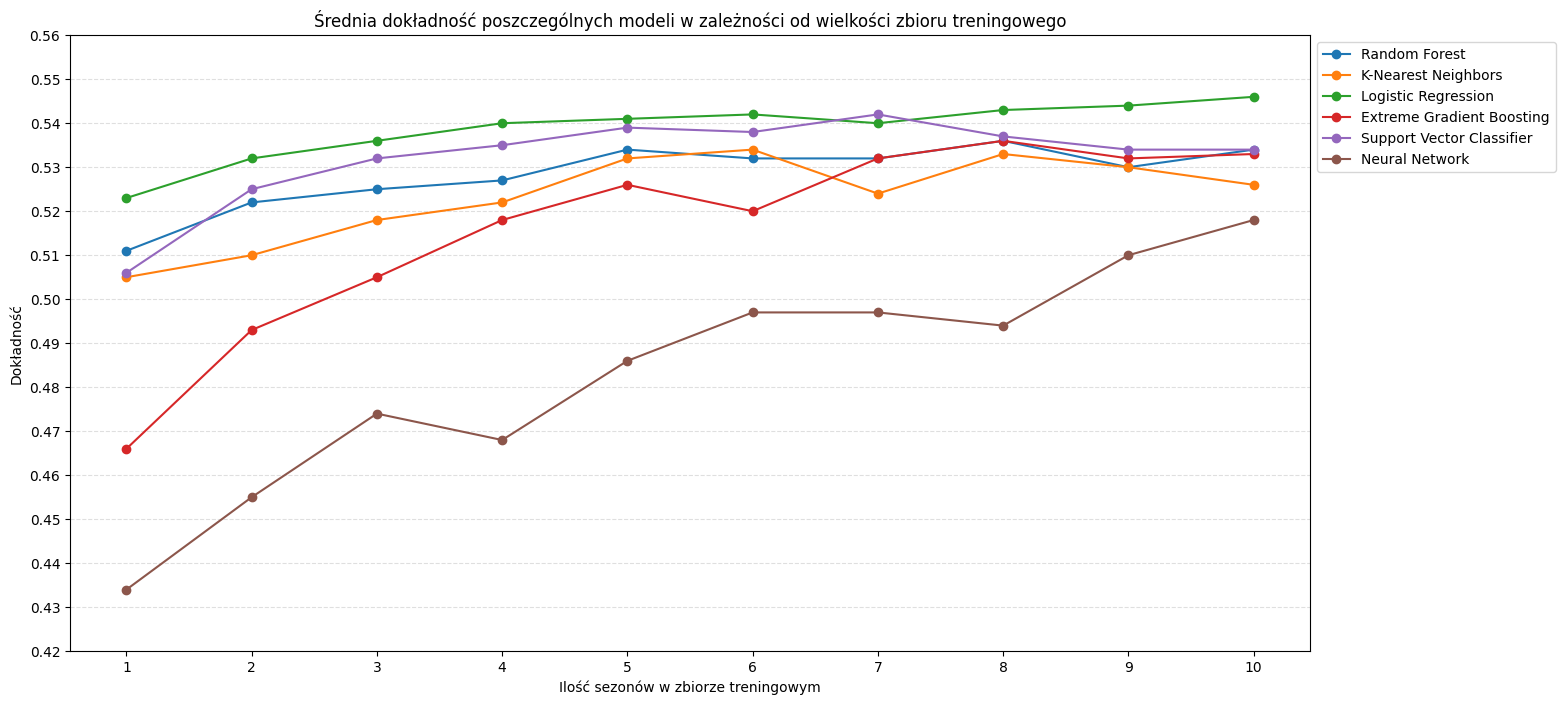

In [108]:
plt.figure(figsize=(16, 8))

for model, accuracies in df_accuracies_mean.iterrows():
    plt.plot(range(1,11), accuracies, marker='o', label=model)

plt.title('Średnia dokładność poszczególnych modeli w zależności od wielkości zbioru treningowego')
plt.xlabel('Ilość sezonów w zbiorze treningowym')
plt.ylabel('Dokładność')
plt.xticks(range(1,11))

min_y = round(df_accuracies_mean.min().min(), 2) - 0.01
max_y = round(df_accuracies_mean.max().max(), 2) + 0.01
    
plt.yticks(np.arange(min_y, max_y , 0.01))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

In [109]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).extend(accuracies_list)

df_accuracies = pd.DataFrame(data).round(3)

df_accuracies

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0           0.517                0.531                0.520   
1           0.508                0.513                0.518   
2           0.467                0.437                0.456   
3           0.487                0.505                0.518   
4           0.546                0.524                0.551   
..            ...                  ...                  ...   
95          0.571                0.592                0.595   
96          0.505                0.511                0.526   
97          0.497                0.497                0.503   
98          0.547                0.525                0.579   
99          0.547                0.525                0.549   

    Extreme Gradient Boosting  Support Vector Classifier  Neural Network  
0                       0.480                      0.533           0.403  
1                       0.497                      0.503           0.424  
2                       0.429                      0.456           0.419  
3                       0.439                      0.495           0.429  
4                       0.492                      0.541           0.449  
..                        ...                        ...             ...  
95                      0.582                      0.597           0.542  
96                      0.529                      0.511           0.500  
97                      0.503                      0.487           0.484  
98                      0.552                      0.557           0.536  
99                      0.523                      0.525           0.499  

[100 rows x 6 columns]

In [110]:
random_forest_df = df_accuracies['Random Forest']
knn_df = df_accuracies['K-Nearest Neighbors']
logistic_regression_df = df_accuracies['Logistic Regression']
xgboost_df = df_accuracies['Extreme Gradient Boosting']
svc_df = df_accuracies['Support Vector Classifier']
neural_network_df = df_accuracies['Neural Network']

dfs = [random_forest_df, knn_df, logistic_regression_df, xgboost_df, svc_df, neural_network_df]

home_wins_by_season = df[df['FTR'] == 'H'].groupby('season')['FTR'].count()
total_matches_by_season = df.groupby('season')['FTR'].count()
home_wins_percentage_by_season = round((home_wins_by_season / total_matches_by_season * 100).fillna(0), 1)
home_wins_percentage_dict = home_wins_percentage_by_season.to_dict()

transformed_dfs = []

for acc_df in dfs:
    array = acc_df.values
    reshaped_array = array.reshape(-1, 10)
    transformed_df = pd.DataFrame(reshaped_array) * 100
    
    transformed_df['średnia'] = round(transformed_df.mean(axis=1), 1)
    
    transformed_dfs.append(transformed_df)

row_labels = [f"{i}" for i in range(1, 11)]
years = range(2013, 2023)

for acc_df in transformed_dfs:
    acc_df.columns = [f"{year}/{str(year+1)[-2:]}" for year in years] + ['średnia']
    acc_df.index = row_labels
    for year in years:
        acc_df.loc['% wygranych gospodarzy', f"{year}/{str(year+1)[-2:]}"] = home_wins_percentage_dict[year]

folder_path = 'accuracies'
algorithm_names = ['rf', 'knn', 'lr', 'xgb', 'svc', 'nn']

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for algorithm_name, acc_df in zip(algorithm_names, transformed_dfs):
    acc_df.iloc[-1, -1] = round(acc_df.iloc[-1, :-1].mean(), 1)
    filename = f'{algorithm_name}_accuracies.xlsx'
    file_path = os.path.join(folder_path, filename)
    acc_df.to_excel(file_path)
    print(f"Zapisano DataFrame do pliku: {file_path}")

Zapisano DataFrame do pliku: accuracies\rf_accuracies.xlsx
Zapisano DataFrame do pliku: accuracies\knn_accuracies.xlsx
Zapisano DataFrame do pliku: accuracies\lr_accuracies.xlsx
Zapisano DataFrame do pliku: accuracies\xgb_accuracies.xlsx
Zapisano DataFrame do pliku: accuracies\svc_accuracies.xlsx
Zapisano DataFrame do pliku: accuracies\nn_accuracies.xlsx


In [111]:
df_accuracies = pd.DataFrame(data).round(3)

In [171]:
df_accuracies

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0           0.517                0.531                0.520   
1           0.508                0.513                0.518   
2           0.467                0.437                0.456   
3           0.487                0.505                0.518   
4           0.546                0.524                0.551   
..            ...                  ...                  ...   
95          0.571                0.592                0.595   
96          0.505                0.511                0.526   
97          0.497                0.497                0.503   
98          0.547                0.525                0.579   
99          0.547                0.525                0.549   

    Extreme Gradient Boosting  Support Vector Classifier  Neural Network  
0                       0.480                      0.533           0.403  
1                       0.497                      0.503           0.424  
2                       0.429                      0.456           0.419  
3                       0.439                      0.495           0.429  
4                       0.492                      0.541           0.449  
..                        ...                        ...             ...  
95                      0.582                      0.597           0.542  
96                      0.529                      0.511           0.500  
97                      0.503                      0.487           0.484  
98                      0.552                      0.557           0.536  
99                      0.523                      0.525           0.499  

[100 rows x 6 columns]

In [112]:
df_accuracies.mean()

Random Forest                0.52845
K-Nearest Neighbors          0.52340
Logistic Regression          0.53883
Extreme Gradient Boosting    0.51626
Support Vector Classifier    0.53236
Neural Network               0.48334
dtype: float64

In [113]:
df_accuracies.max()

Random Forest                0.605
K-Nearest Neighbors          0.605
Logistic Regression          0.605
Extreme Gradient Boosting    0.605
Support Vector Classifier    0.603
Neural Network               0.589
dtype: float64

In [167]:
df_accuracies.min()

Random Forest                0.424
K-Nearest Neighbors          0.421
Logistic Regression          0.443
Extreme Gradient Boosting    0.426
Support Vector Classifier    0.437
Neural Network               0.379
dtype: float64

In [115]:
df_accuracies.iloc[59:].mean()

Random Forest                0.533024
K-Nearest Neighbors          0.528415
Logistic Regression          0.543537
Extreme Gradient Boosting    0.532951
Support Vector Classifier    0.536951
Neural Network               0.503976
dtype: float64

In [116]:
df_accuracies.iloc[59:].max()

Random Forest                0.597
K-Nearest Neighbors          0.600
Logistic Regression          0.605
Extreme Gradient Boosting    0.595
Support Vector Classifier    0.600
Neural Network               0.589
dtype: float64

In [117]:
df_accuracies.iloc[59:].min()

Random Forest                0.448
K-Nearest Neighbors          0.421
Logistic Regression          0.443
Extreme Gradient Boosting    0.451
Support Vector Classifier    0.437
Neural Network               0.437
dtype: float64

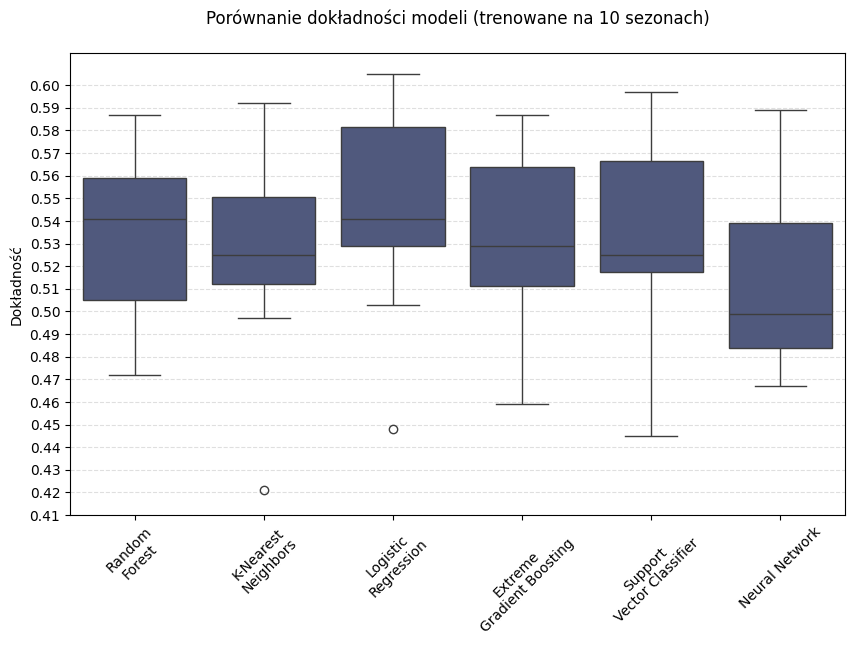

In [197]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(data=df_accuracies.iloc[89:], color=colors[0])
plt.title('Porównanie dokładności modeli (trenowane na 10 sezonach)\n')
plt.ylabel('Dokładność')
plt.xticks(rotation=45)

min_y = round(df_accuracies.iloc[89:].min().min(), 2) - 0.01
max_y = round(df_accuracies.iloc[89:].max().max(), 2) + 0.01
plt.yticks(np.arange(min_y, max_y , 0.01))

custom_labels = [
    'Random\nForest', 'K-Nearest\nNeighbors', 'Logistic\nRegression', 'Extreme\nGradient Boosting', 
    'Support\nVector Classifier', 'Neural Network']
plt.gca().set_xticklabels(custom_labels)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [119]:
data_dict = {}

for model, data_dict_model in correct_predictions_by_team.items():
    for team, correct_predictions in data_dict_model.items():
        if team not in data_dict:
            data_dict[team] = {}
        total_predictions = number_of_predictions_by_team[team]
        percentage_correct = (correct_predictions / total_predictions)
        data_dict[team][model] = percentage_correct

correct_predictions_df = pd.DataFrame(data_dict).transpose()
correct_predictions_df.reset_index(inplace=True)
correct_predictions_df.rename(columns={'index': 'team'}, inplace=True)
correct_predictions_df = correct_predictions_df.round(2)

correct_predictions_df.head()

team  Random Forest  K-Nearest Neighbors  Logistic Regression  \
0   Liverpool           0.62                 0.61                 0.62   
1       Stoke           0.48                 0.46                 0.48   
2     Swansea           0.53                 0.51                 0.53   
3  Man United           0.55                 0.55                 0.54   
4     Chelsea           0.56                 0.56                 0.57   

   Extreme Gradient Boosting  Support Vector Classifier  Neural Network  
0                       0.61                       0.62            0.56  
1                       0.46                       0.48            0.43  
2                       0.55                       0.54            0.50  
3                       0.55                       0.55            0.52  
4                       0.56                       0.55            0.53

In [120]:
filtered_standings = standings[(standings['season'] >= 2013) & (standings['season'] <= 2022)]
average_position_df = filtered_standings.groupby('team')['position'].mean().reset_index()
average_position_df = average_position_df.sort_values(by='position')
average_position_df = average_position_df.rename(columns={'position': 'average_position'})
average_position_df.reset_index(drop=True, inplace=True)

average_position_df.head()

team  average_position
0    Man City               1.7
1   Liverpool               3.7
2  Man United               4.4
3     Chelsea               4.6
4   Tottenham               4.8

In [121]:
merged_df = pd.merge(average_position_df, correct_predictions_df, on='team')

merged_df.head()

team  average_position  Random Forest  K-Nearest Neighbors  \
0    Man City               1.7           0.71                 0.72   
1   Liverpool               3.7           0.62                 0.61   
2  Man United               4.4           0.55                 0.55   
3     Chelsea               4.6           0.56                 0.56   
4   Tottenham               4.8           0.58                 0.55   

   Logistic Regression  Extreme Gradient Boosting  Support Vector Classifier  \
0                 0.71                       0.70                       0.71   
1                 0.62                       0.61                       0.62   
2                 0.54                       0.55                       0.55   
3                 0.57                       0.56                       0.55   
4                 0.59                       0.56                       0.59   

   Neural Network  
0            0.66  
1            0.56  
2            0.52  
3            0.53  
4            0.55

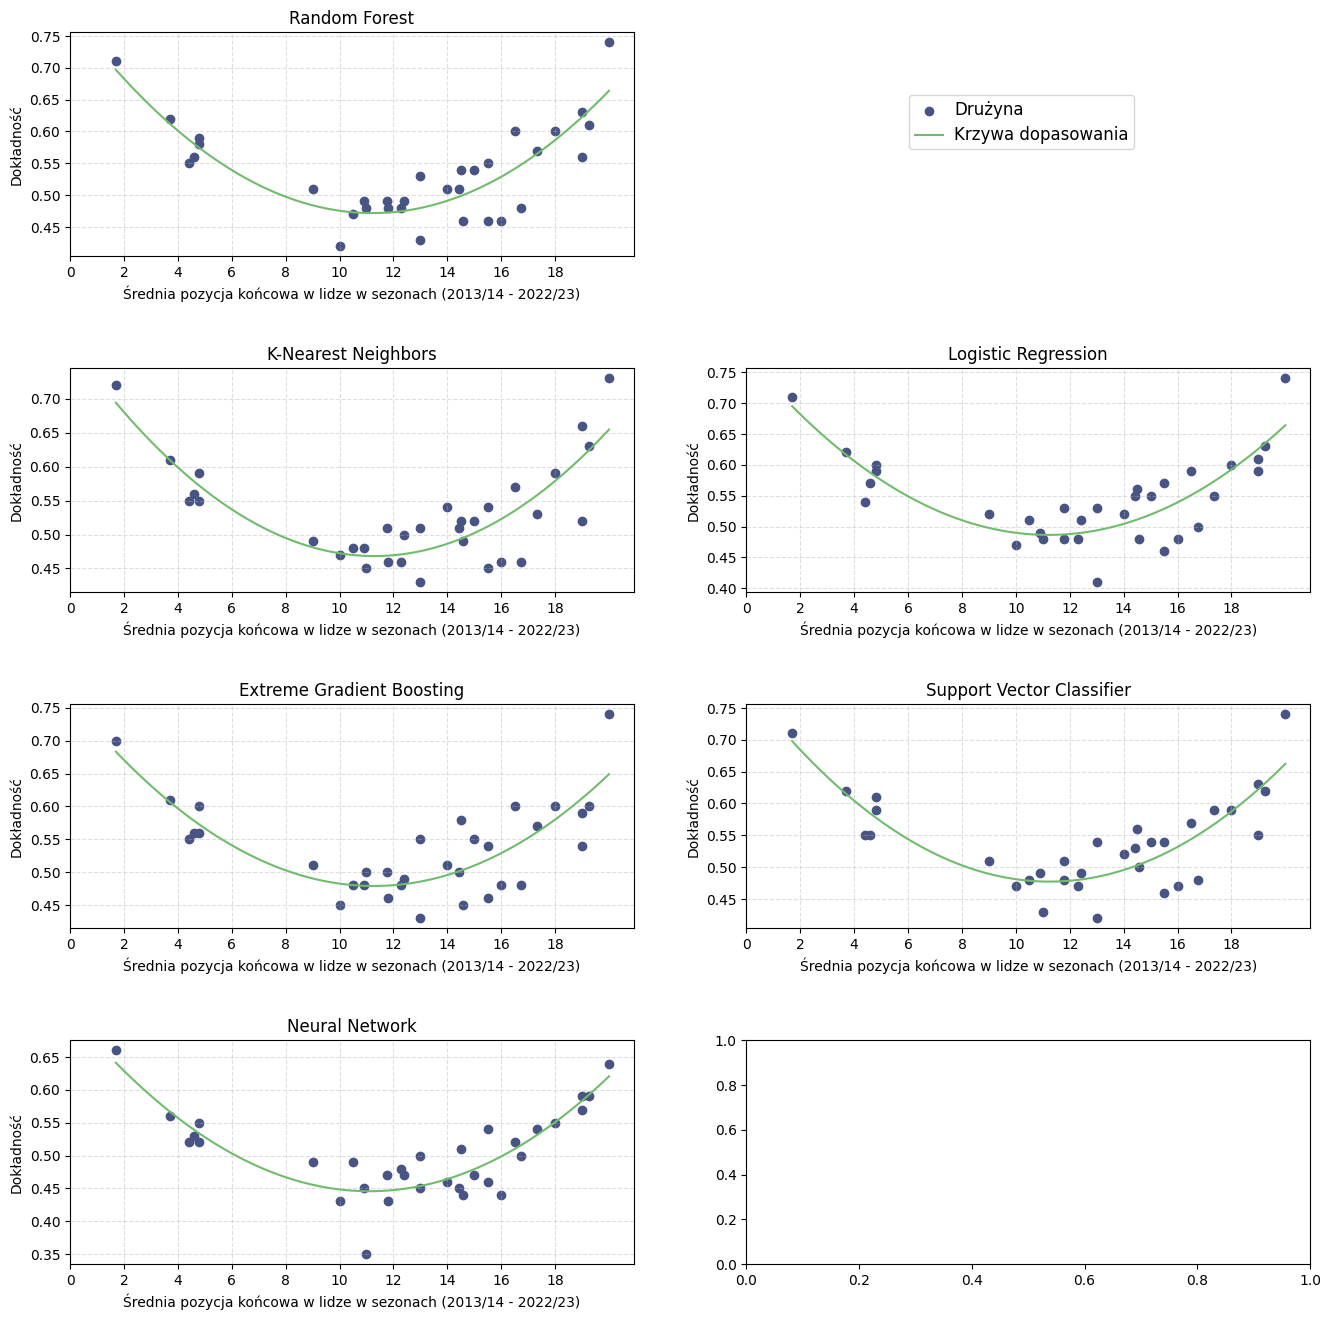

In [122]:
models = ['Random Forest', 'K-Nearest Neighbors', 'Logistic Regression', 'Extreme Gradient Boosting', 
          'Support Vector Classifier', 'Neural Network']

def parabolic_func(x, a, b, c):
    return a * x**2 + b * x + c

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16), gridspec_kw={'hspace': 0.5})

for i, model in enumerate(models):
    if i != 0:  
        i+= 1
        
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    ax.scatter(merged_df['average_position'], merged_df[model], color=colors[0], label='Drużyna')
    
    x_data = merged_df['average_position']
    y_data = merged_df[model]
    popt, _ = curve_fit(parabolic_func, x_data, y_data)
    x_fit = np.linspace(min(x_data), max(x_data), 100)
    y_fit = parabolic_func(x_fit, *popt)
    ax.plot(x_fit, y_fit, color=colors[2], label='Krzywa dopasowania')
    
    ax.set_xlabel('Średnia pozycja końcowa w lidze w sezonach (2013/14 - 2022/23)')
    ax.set_ylabel('Dokładność')
    ax.set_title(model)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_xticks(np.arange(0, 20, 2))

axes[0, 1].remove()
plt.sca(axes[0, 0])
legend = plt.legend(bbox_to_anchor=(1.9, 0.75))
for text in legend.get_texts():
    text.set_fontsize(12)

plt.tight_layout()
plt.show()


***
Zbalansowany zbior treningowy (oversampling)

In [123]:
models = [rf, knn, lr, xgb, svc, nn]

model_names = {
    'randomforestclassifier': 'Random Forest',
    'kneighborsclassifier': 'K-Nearest Neighbors',
    'logisticregression': 'Logistic Regression',
    'xgbclassifier': 'Extreme Gradient Boosting',
    'svc': 'Support Vector Classifier',
    'sequential': 'Neural Network',
}

accuracies_full = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

for key, value in sets.items():
    accuracies = {model_names[model.__class__.__name__.lower()]: [] for model in models}

    for model in models:
        
        i = int(re.findall(r'\d+', key)[0])
        
        print('^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v')
        print(f'Training {model_names[model.__class__.__name__.lower()]} model on {i} season/s\n')
        
        for train, test in zip(value[0], value[1]):
            
            class_counts = train['FTR'].value_counts()
            majority_class = class_counts.idxmax()

            balanced_train = pd.concat([
                resample(train[train['FTR'] == cls], 
                         replace=True,
                         n_samples=class_counts[majority_class],
                         random_state=42)
                for cls in class_counts.index
            ])

            X_train = balanced_train[predictors]
            y_train = balanced_train['target']
            
            X_test = test[predictors]
            y_test = test['target']
            
            print(f'Training season/s: {pd.concat([train["season"]]).unique().tolist()}')
            print(f'Test season: {pd.concat([test["season"]]).unique().tolist()}')
            
            if model == nn:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)

            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)

            accuracy = accuracy_score(y_test, preds)
            accuracies[model_names[model.__class__.__name__.lower()]].append(accuracy)
            
            print(f'Accuracy: {accuracy}\n')
            
    accuracies_full[key].append(accuracies)      

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.5146666666666667

Training season/s: [2013]
Test season: [2014]
Accuracy: 0.4842105263157895

Training season/s: [2014]
Test season: [2015]
Accuracy: 0.42133333333333334

Training season/s: [2015]
Test season: [2016]
Accuracy: 0.4394736842105263

Training season/s: [2016]
Test season: [2017]
Accuracy: 0.5081081081081081

Training season/s: [2017]
Test season: [2018]
Accuracy: 0.46578947368421053

Training season/s: [2018]
Test season: [2019]
Accuracy: 0.49473684210526314

Training season/s: [2019]
Test season: [2020]
Accuracy: 0.43157894736842106

Training season/s: [2020]
Test season: [2021]
Accuracy: 0.432

Training season/s: [2021]
Test season: [2022]
Accuracy: 0.448

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.45066666666666666

Train

Accuracy: 0.4826666666666667

Training season/s: [2012, 2013]
Test season: [2014]
Accuracy: 0.45526315789473687

Training season/s: [2013, 2014]
Test season: [2015]
Accuracy: 0.4186666666666667

Training season/s: [2014, 2015]
Test season: [2016]
Accuracy: 0.46578947368421053

Training season/s: [2015, 2016]
Test season: [2017]
Accuracy: 0.45135135135135135

Training season/s: [2016, 2017]
Test season: [2018]
Accuracy: 0.5052631578947369

Training season/s: [2017, 2018]
Test season: [2019]
Accuracy: 0.46842105263157896

Training season/s: [2018, 2019]
Test season: [2020]
Accuracy: 0.4421052631578947

Training season/s: [2019, 2020]
Test season: [2021]
Accuracy: 0.4826666666666667

Training season/s: [2020, 2021]
Test season: [2022]
Accuracy: 0.43466666666666665

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 2 season/s

Training season/s: [2011, 2012]
Test season: [2013]
Accuracy: 0.5226666666666666

Training season/s: [2012, 2013]
Test season: [2014]
Accur

Accuracy: 0.47733333333333333

Training season/s: [2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.48533333333333334

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 4 season/s

Training season/s: [2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.49066666666666664

Training season/s: [2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4710526315789474

Training season/s: [2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.42933333333333334

Training season/s: [2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.4131578947368421

Training season/s: [2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4594594594594595

Training season/s: [2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.4763157894736842

Training season/s: [2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4868421052631579

Training season/s: [2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4394736842105263

Training season/s: [2017, 2

Accuracy: 0.464

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Extreme Gradient Boosting model on 5 season/s

Training season/s: [2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.48533333333333334

Training season/s: [2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4710526315789474

Training season/s: [2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4186666666666667

Training season/s: [2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.4763157894736842

Training season/s: [2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5108108108108108

Training season/s: [2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.4842105263157895

Training season/s: [2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.45789473684210524

Training season/s: [2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4342105263157895

Training season/s: [2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.

Accuracy: 0.5052631578947369

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5394736842105263

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4631578947368421

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4368421052631579

Training season/s: [2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.4666666666666667

Training season/s: [2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.42933333333333334

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 6 season/s

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.544

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.48947368421052634

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014]
Test

Accuracy: 0.5421052631578948

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4891891891891892

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5473684210526316

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4763157894736842

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.5236842105263158

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.528

Training season/s: [2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.456

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 8 season/s

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.536

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4763157894736842

Training seaso

Accuracy: 0.5226666666666666

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4605263157894737

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.408

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5131578947368421

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5368421052631579

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5052631578947369

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.46842105263157896

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.49066666666666664

Trai

Accuracy: 0.5342105263157895

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5027027027027027

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5421052631578948

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5210526315789473

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4710526315789474

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.5226666666666666

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.4693333333333333

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 10 season/s

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [20

In [124]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).extend(accuracies_list)

df_oversampling_accuracies = pd.DataFrame(data).round(2)

df_oversampling_accuracies

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0            0.51                 0.45                 0.48   
1            0.48                 0.45                 0.46   
2            0.42                 0.38                 0.43   
3            0.44                 0.42                 0.48   
4            0.51                 0.46                 0.48   
..            ...                  ...                  ...   
95           0.54                 0.52                 0.54   
96           0.52                 0.45                 0.49   
97           0.47                 0.45                 0.48   
98           0.52                 0.45                 0.49   
99           0.47                 0.45                 0.50   

    Extreme Gradient Boosting  Support Vector Classifier  Neural Network  
0                        0.41                       0.49            0.56  
1                        0.43                       0.38            0.54  
2                        0.41                       0.43            0.49  
3                        0.43                       0.46            0.55  
4                        0.44                       0.48            0.52  
..                        ...                        ...             ...  
95                       0.52                       0.55            0.58  
96                       0.47                       0.47            0.49  
97                       0.50                       0.44            0.53  
98                       0.50                       0.49            0.52  
99                       0.46                       0.45            0.47  

[100 rows x 6 columns]

In [125]:
df_oversampling_accuracies.mean()

Random Forest                0.4921
K-Nearest Neighbors          0.4504
Logistic Regression          0.4908
Extreme Gradient Boosting    0.4705
Support Vector Classifier    0.4715
Neural Network               0.4943
dtype: float64

In [126]:
df_oversampling_accuracies.max()

Random Forest                0.57
K-Nearest Neighbors          0.54
Logistic Regression          0.59
Extreme Gradient Boosting    0.55
Support Vector Classifier    0.57
Neural Network               0.61
dtype: float64

In [127]:
df_oversampling_accuracies.min()

Random Forest                0.41
K-Nearest Neighbors          0.38
Logistic Regression          0.41
Extreme Gradient Boosting    0.38
Support Vector Classifier    0.37
Neural Network               0.25
dtype: float64

In [128]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).append(np.mean(accuracies_list))

df_oversampling_accuracies_mean = pd.DataFrame(data).round(3)

df_oversampling_accuracies_mean

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0          0.464                0.428                0.469   
1          0.495                0.437                0.485   
2          0.498                0.437                0.489   
3          0.490                0.454                0.497   
4          0.497                0.462                0.497   
5          0.494                0.457                0.491   
6          0.500                0.459                0.495   
7          0.498                0.454                0.487   
8          0.487                0.453                0.494   
9          0.500                0.462                0.498   

   Extreme Gradient Boosting  Support Vector Classifier  Neural Network  
0                      0.439                      0.442           0.503  
1                      0.456                      0.461           0.465  
2                      0.468                      0.461           0.451  
3                      0.460                      0.477           0.462  
4                      0.467                      0.478           0.495  
5                      0.485                      0.478           0.498  
6                      0.481                      0.481           0.504  
7                      0.480                      0.485           0.514  
8                      0.483                      0.477           0.521  
9                      0.489                      0.476           0.529

In [129]:
df_oversampling_accuracies_mean = df_oversampling_accuracies_mean.T
df_oversampling_accuracies_mean

0      1      2      3      4      5      6  \
Random Forest              0.464  0.495  0.498  0.490  0.497  0.494  0.500   
K-Nearest Neighbors        0.428  0.437  0.437  0.454  0.462  0.457  0.459   
Logistic Regression        0.469  0.485  0.489  0.497  0.497  0.491  0.495   
Extreme Gradient Boosting  0.439  0.456  0.468  0.460  0.467  0.485  0.481   
Support Vector Classifier  0.442  0.461  0.461  0.477  0.478  0.478  0.481   
Neural Network             0.503  0.465  0.451  0.462  0.495  0.498  0.504   

                               7      8      9  
Random Forest              0.498  0.487  0.500  
K-Nearest Neighbors        0.454  0.453  0.462  
Logistic Regression        0.487  0.494  0.498  
Extreme Gradient Boosting  0.480  0.483  0.489  
Support Vector Classifier  0.485  0.477  0.476  
Neural Network             0.514  0.521  0.529

***
Zbalansowany zbior treningowy (undersampling)

In [130]:
models = [rf, knn, lr, xgb, svc, nn]

model_names = {
    'randomforestclassifier': 'Random Forest',
    'kneighborsclassifier': 'K-Nearest Neighbors',
    'logisticregression': 'Logistic Regression',
    'xgbclassifier': 'Extreme Gradient Boosting',
    'svc': 'Support Vector Classifier',
    'sequential': 'Neural Network',
}

accuracies_full = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

for key, value in sets.items():
    accuracies = {model_names[model.__class__.__name__.lower()]: [] for model in models}

    for model in models:
        
        i = int(re.findall(r'\d+', key)[0])
        
        print('^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v')
        print(f'Training {model_names[model.__class__.__name__.lower()]} model on {i} season/s\n')
        
        for train, test in zip(value[0], value[1]):
            
            class_counts = train['FTR'].value_counts()
            minority_class = class_counts.idxmin()

            balanced_train = pd.concat([
                resample(train[train['FTR'] == cls], 
                         replace=False,
                         n_samples=class_counts[minority_class],
                         random_state=42)
                for cls in class_counts.index
            ])

            X_train = balanced_train[predictors]
            y_train = balanced_train['target']
            
            X_test = test[predictors]
            y_test = test['target']
            
            print(f'Training season/s: {pd.concat([train["season"]]).unique().tolist()}')
            print(f'Test season: {pd.concat([test["season"]]).unique().tolist()}')
            
            if model == nn:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)

            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)

            accuracy = accuracy_score(y_test, preds)
            accuracies[model_names[model.__class__.__name__.lower()]].append(accuracy)
            
            print(f'Accuracy: {accuracy}\n')
            
    accuracies_full[key].append(accuracies)      

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.47733333333333333

Training season/s: [2013]
Test season: [2014]
Accuracy: 0.49473684210526314

Training season/s: [2014]
Test season: [2015]
Accuracy: 0.464

Training season/s: [2015]
Test season: [2016]
Accuracy: 0.46842105263157896

Training season/s: [2016]
Test season: [2017]
Accuracy: 0.47297297297297297

Training season/s: [2017]
Test season: [2018]
Accuracy: 0.5026315789473684

Training season/s: [2018]
Test season: [2019]
Accuracy: 0.4763157894736842

Training season/s: [2019]
Test season: [2020]
Accuracy: 0.45263157894736844

Training season/s: [2020]
Test season: [2021]
Accuracy: 0.464

Training season/s: [2021]
Test season: [2022]
Accuracy: 0.4186666666666667

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.45066666666666666

Trai

Accuracy: 0.488

Training season/s: [2012, 2013]
Test season: [2014]
Accuracy: 0.49736842105263157

Training season/s: [2013, 2014]
Test season: [2015]
Accuracy: 0.45866666666666667

Training season/s: [2014, 2015]
Test season: [2016]
Accuracy: 0.5157894736842106

Training season/s: [2015, 2016]
Test season: [2017]
Accuracy: 0.5162162162162162

Training season/s: [2016, 2017]
Test season: [2018]
Accuracy: 0.5078947368421053

Training season/s: [2017, 2018]
Test season: [2019]
Accuracy: 0.45526315789473687

Training season/s: [2018, 2019]
Test season: [2020]
Accuracy: 0.40789473684210525

Training season/s: [2019, 2020]
Test season: [2021]
Accuracy: 0.448

Training season/s: [2020, 2021]
Test season: [2022]
Accuracy: 0.48533333333333334

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 2 season/s

Training season/s: [2011, 2012]
Test season: [2013]
Accuracy: 0.5466666666666666

Training season/s: [2012, 2013]
Test season: [2014]
Accuracy: 0.5184210526315789

T

Accuracy: 0.488

Training season/s: [2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.4053333333333333

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 4 season/s

Training season/s: [2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.488

Training season/s: [2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4605263157894737

Training season/s: [2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.41333333333333333

Training season/s: [2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.45

Training season/s: [2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4891891891891892

Training season/s: [2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.49736842105263157

Training season/s: [2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.45263157894736844

Training season/s: [2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.44473684210526315

Training season/s: [2017, 2018, 2019, 2020]
Test season: [2021]
Acc

Accuracy: 0.4693333333333333

Training season/s: [2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.4666666666666667

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Extreme Gradient Boosting model on 5 season/s

Training season/s: [2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.512

Training season/s: [2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4921052631578947

Training season/s: [2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.41333333333333333

Training season/s: [2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5052631578947369

Training season/s: [2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4918918918918919

Training season/s: [2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.49473684210526314

Training season/s: [2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5052631578947369

Training season/s: [2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4106666666666667

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5131578947368421

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5054054054054054

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5578947368421052

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4631578947368421

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4605263157894737

Training season/s: [2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.48

Training season/s: [2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.43466666666666665

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 6 season/s

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
A

Accuracy: 0.5394736842105263

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.5146666666666667

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5894736842105263

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5631578947368421

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.46842105263157896

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.5526315789473685

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.5173333333333333

Training season/s: [2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.4746666666666667

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 8 season/s

T

Accuracy: 0.536

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.5146666666666667

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 9 season/s

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.512

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5026315789473684

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.44533333333333336

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5157894736842106

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4891891891891892

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5131578947368421

Training season/s: [2010, 2011, 2012, 2013, 20

Accuracy: 0.4868421052631579

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.43733333333333335

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5578947368421052

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4756756756756757

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5184210526315789

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5157894736842106

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.44473684210526315

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.512

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 202

In [131]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).extend(accuracies_list)

df_undersampling_accuracies = pd.DataFrame(data).round(2)

df_undersampling_accuracies

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0            0.48                 0.45                 0.50   
1            0.49                 0.45                 0.50   
2            0.46                 0.41                 0.41   
3            0.47                 0.47                 0.47   
4            0.47                 0.47                 0.48   
..            ...                  ...                  ...   
95           0.52                 0.53                 0.52   
96           0.52                 0.49                 0.51   
97           0.44                 0.44                 0.45   
98           0.51                 0.48                 0.50   
99           0.47                 0.47                 0.47   

    Extreme Gradient Boosting  Support Vector Classifier  Neural Network  
0                        0.45                       0.45            0.55  
1                        0.47                       0.45            0.53  
2                        0.42                       0.40            0.53  
3                        0.40                       0.47            0.61  
4                        0.38                       0.46            0.52  
..                        ...                        ...             ...  
95                       0.53                       0.54            0.58  
96                       0.49                       0.49            0.49  
97                       0.44                       0.46            0.53  
98                       0.50                       0.48            0.53  
99                       0.46                       0.46            0.50  

[100 rows x 6 columns]

In [132]:
df_undersampling_accuracies.mean()

Random Forest                0.4843
K-Nearest Neighbors          0.4633
Logistic Regression          0.4943
Extreme Gradient Boosting    0.4727
Support Vector Classifier    0.4744
Neural Network               0.5249
dtype: float64

In [133]:
df_undersampling_accuracies.max()

Random Forest                0.56
K-Nearest Neighbors          0.54
Logistic Regression          0.56
Extreme Gradient Boosting    0.56
Support Vector Classifier    0.56
Neural Network               0.62
dtype: float64

In [134]:
df_undersampling_accuracies.min()

Random Forest                0.40
K-Nearest Neighbors          0.38
Logistic Regression          0.40
Extreme Gradient Boosting    0.38
Support Vector Classifier    0.40
Neural Network               0.39
dtype: float64

In [135]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).append(np.mean(accuracies_list))

df_undersampling_accuracies_mean = pd.DataFrame(data).round(3)

df_undersampling_accuracies_mean

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0          0.469                0.450                0.472   
1          0.482                0.451                0.492   
2          0.483                0.450                0.493   
3          0.483                0.456                0.494   
4          0.482                0.463                0.494   
5          0.483                0.461                0.495   
6          0.486                0.476                0.501   
7          0.487                0.477                0.498   
8          0.496                0.471                0.503   
9          0.495                0.477                0.502   

   Extreme Gradient Boosting  Support Vector Classifier  Neural Network  
0                      0.421                      0.436           0.523  
1                      0.448                      0.478           0.510  
2                      0.467                      0.467           0.509  
3                      0.471                      0.465           0.497  
4                      0.482                      0.473           0.524  
5                      0.474                      0.481           0.532  
6                      0.485                      0.482           0.531  
7                      0.487                      0.484           0.546  
8                      0.497                      0.487           0.544  
9                      0.493                      0.487           0.534

In [136]:
df_undersampling_accuracies_mean = df_undersampling_accuracies_mean.T
df_undersampling_accuracies_mean

0      1      2      3      4      5      6  \
Random Forest              0.469  0.482  0.483  0.483  0.482  0.483  0.486   
K-Nearest Neighbors        0.450  0.451  0.450  0.456  0.463  0.461  0.476   
Logistic Regression        0.472  0.492  0.493  0.494  0.494  0.495  0.501   
Extreme Gradient Boosting  0.421  0.448  0.467  0.471  0.482  0.474  0.485   
Support Vector Classifier  0.436  0.478  0.467  0.465  0.473  0.481  0.482   
Neural Network             0.523  0.510  0.509  0.497  0.524  0.532  0.531   

                               7      8      9  
Random Forest              0.487  0.496  0.495  
K-Nearest Neighbors        0.477  0.471  0.477  
Logistic Regression        0.498  0.503  0.502  
Extreme Gradient Boosting  0.487  0.497  0.493  
Support Vector Classifier  0.484  0.487  0.487  
Neural Network             0.546  0.544  0.534

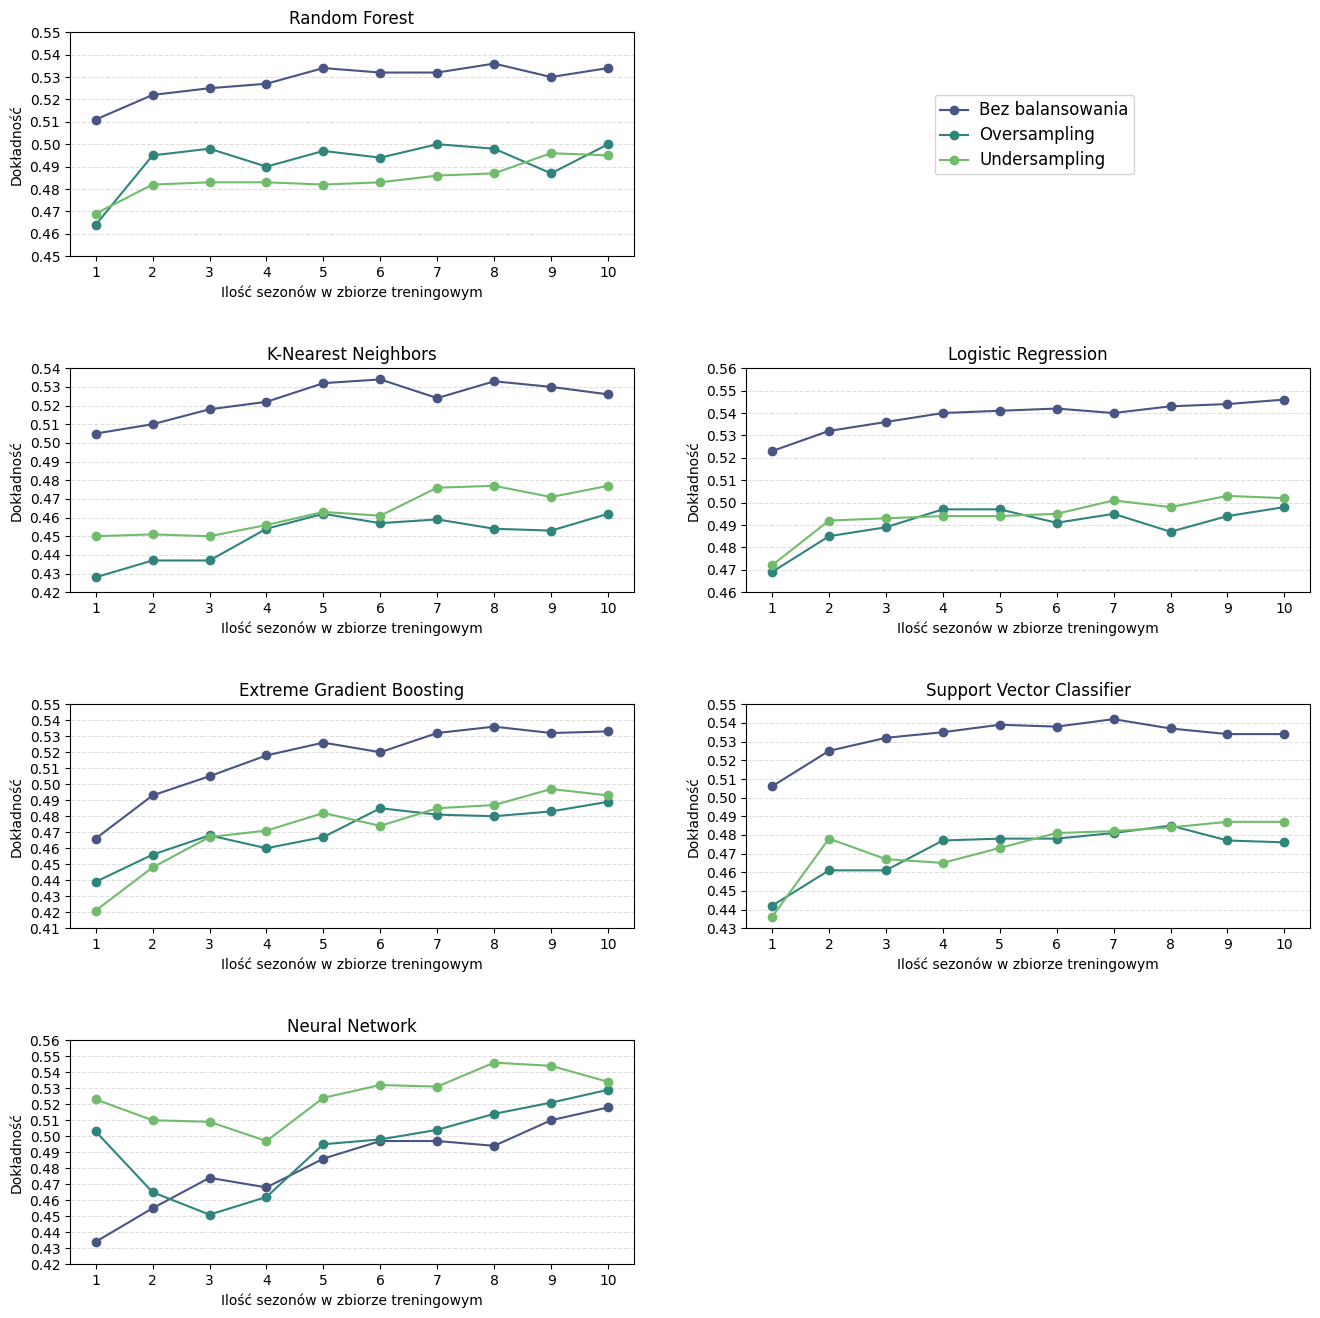

In [147]:
models = [
    'Random Forest', 'K-Nearest Neighbors', 'Logistic Regression', 'Extreme Gradient Boosting', 
    'Support Vector Classifier', 'Neural Network'
]

colors = ['#485484', '#30847c', '#70bc6c']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16) , gridspec_kw={'hspace': 0.5})

for i, model in enumerate(models):
    if i != 0:  
        i+= 1
        
    row = i // 2
    col = i % 2
    
    plt.sca(axes[row, col])
    
    accuracies = df_accuracies_mean.loc[model]
    oversampling_accuracies = df_oversampling_accuracies_mean.loc[model]
    undersampling_accuracies = df_undersampling_accuracies_mean.loc[model]
    
    plt.plot(range(1, 11), accuracies, marker='o', label='Bez balansowania', color=colors[0])
    plt.plot(range(1, 11), oversampling_accuracies, marker='o', label='Oversampling', color=colors[1])
    plt.plot(range(1, 11), undersampling_accuracies, marker='o', label='Undersampling', color=colors[2])
    
    merged = []
    merged.extend(accuracies)
    merged.extend(oversampling_accuracies)
    merged.extend(undersampling_accuracies)
    
    min_y = round(min(merged), 2) - 0.01
    max_y = round(max(merged), 2) + 0.01
    
    plt.title(model)
    plt.xlabel('Ilość sezonów w zbiorze treningowym')
    plt.ylabel('Dokładność')
    plt.xticks(range(1, 11))
    plt.yticks(np.arange(min_y, max_y, 0.01))
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    
axes[0, 1].remove()
axes[3, 1].remove()
plt.sca(axes[0, 0])
legend = plt.legend(bbox_to_anchor=(1.9, 0.75))
for text in legend.get_texts():
    text.set_fontsize(12)

plt.tight_layout()
plt.show()

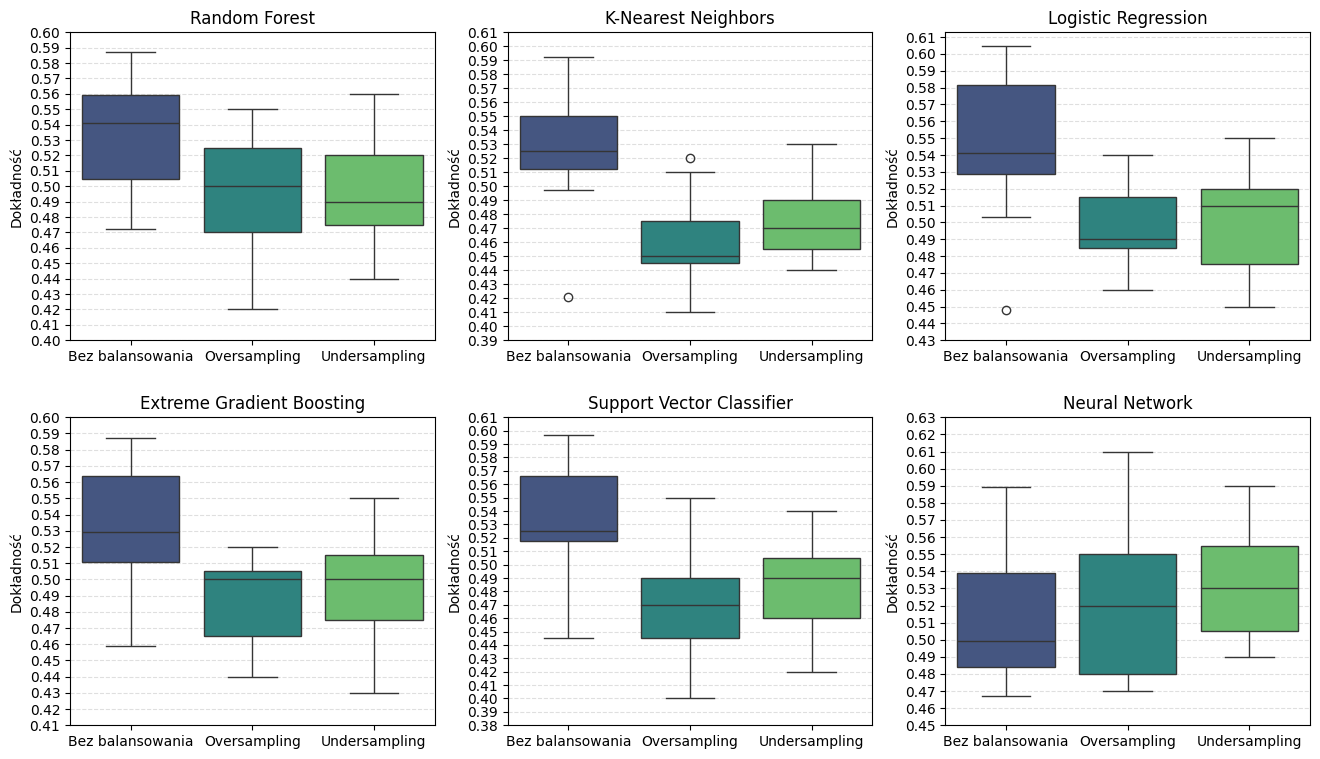

In [198]:
models = [
    'Random Forest', 'K-Nearest Neighbors', 'Logistic Regression', 'Extreme Gradient Boosting', 
    'Support Vector Classifier', 'Neural Network'
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 9) , gridspec_kw={'hspace': 0.25})

for i, model in enumerate(models):
    row = i // 3
    col = i % 3
    
    data = pd.concat([
        df_accuracies[model].iloc[89:], 
        df_oversampling_accuracies[model].iloc[89:], 
        df_undersampling_accuracies[model].iloc[89:]
    ], axis=1, keys=['Bez balansowania', 'Oversampling', 'Undersampling'])
    
    min_y = round(data.min().min(), 2) - 0.02
    max_y = round(data.max().max(), 2) + 0.02
    
    sns.boxplot(data=data, ax=axes[row, col], palette='viridis')
    axes[row, col].set_title(model)
    axes[row, col].set_ylabel('Dokładność')
    axes[row, col].set_xticklabels(['Bez balansowania', 'Oversampling', 'Undersampling'])
    axes[row, col].set_yticks(np.arange(min_y, max_y, 0.01))
    axes[row, col].grid(axis='y', linestyle='--', alpha=0.4)
    

plt.tight_layout()
plt.show()

In [139]:
nn_o = copy.deepcopy(nn)
nn_u = copy.deepcopy(nn)

models = [rf, knn, lr, xgb, svc, nn, nn_o, nn_u]

model_names = {
    'randomforestclassifier': 'Random Forest',
    'kneighborsclassifier': 'K-Nearest Neighbors',
    'logisticregression': 'Logistic Regression',
    'xgbclassifier': 'Extreme Gradient Boosting',
    'svc': 'Support Vector Classifier',
    'sequential': 'Neural Network'
}

profit = {model_names[model] : [] for model in model_names}
profit['Neural Network (Oversampling)'] = []
profit['Neural Network (Undersampling)'] = []

correct_preds_odds = {model_names[model] : [] for model in model_names}
correct_preds_odds['Neural Network (Oversampling)'] = []
correct_preds_odds['Neural Network (Undersampling)'] = []

for model in models:
        
        print('\n^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v')
        print(f'Training {model_names[model.__class__.__name__.lower()]} model on 10 season/s\n')
        
        for train, test in zip(sets['trained_on_10_seasons'][0], sets['trained_on_10_seasons'][1]):
            
            season_profit = 0

            X_train = train[predictors]
            y_train = train['target']
            
            X_test = test[predictors]
            y_test = test['target']
            
            print(f'Training season/s: {pd.concat([train["season"]]).unique().tolist()}')
            print(f'Test season: {pd.concat([test["season"]]).unique().tolist()}')
            
            if model == nn:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)
            
            elif model == nn_o:
                class_counts = train['FTR'].value_counts()
                majority_class = class_counts.idxmax()

                balanced_train = pd.concat([
                    resample(train[train['FTR'] == cls], 
                             replace=True,
                             n_samples=class_counts[majority_class],
                             random_state=42)
                    for cls in class_counts.index
                ])

                X_train = balanced_train[predictors]
                y_train = balanced_train['target']

                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)
                
            elif model == nn_u:
                class_counts = train['FTR'].value_counts()
                minority_class = class_counts.idxmin()

                balanced_train = pd.concat([
                    resample(train[train['FTR'] == cls], 
                             replace=False,
                             n_samples=class_counts[minority_class],
                             random_state=42)
                    for cls in class_counts.index
                ])

                X_train = balanced_train[predictors]
                y_train = balanced_train['target']

                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)
                
            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                
            for pred_label, actual_label, index in zip(preds, y_test, y_test.index):
                if pred_label == actual_label:
                    if pred_label == 0:
                        odds = df.loc[index, 'OH']
                        season_profit += ((1 * odds) - 1)
                    if pred_label == 1:
                        odds = df.loc[index, 'OD']
                        season_profit += ((1 * odds) - 1)
                    if pred_label == 2:
                        odds = df.loc[index, 'OA']
                        season_profit += ((1 * odds) - 1)
                        
                    if model == nn_o:
                        correct_preds_odds['Neural Network (Oversampling)'].append(odds)
                        
                    elif model == nn_u:
                        correct_preds_odds['Neural Network (Undersampling)'].append(odds)
                        
                    else:
                        correct_preds_odds[model_names[model.__class__.__name__.lower()]].append(odds)
                    
                else:
                    season_profit -= 1
                    
            season_profit = round(season_profit, 2)
            if model == nn_o:
                profit['Neural Network (Oversampling)'].append(season_profit)
                        
            elif model == nn_u:
                profit['Neural Network (Undersampling)'].append(season_profit)
                        
            else:
                profit[model_names[model.__class__.__name__.lower()]].append(season_profit)
            print(f'Profit this season: {season_profit} PLN\n')       


^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 10 season/s

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Profit this season: 30.71 PLN

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Profit this season: -31.65 PLN

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Profit this season: -24.38 PLN

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Profit this season: 20.51 PLN

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Profit this season: -37.24 PLN

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Profit this season: -0.86 PLN

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Profit this season: -4

Profit this season: 38.47 PLN

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Profit this season: 18.6 PLN


^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 10 season/s

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Profit this season: 73.09 PLN

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Profit this season: 43.55 PLN

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Profit this season: 13.62 PLN

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Profit this season: 35.71 PLN

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Profit this season: -38.81 PLN

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: 

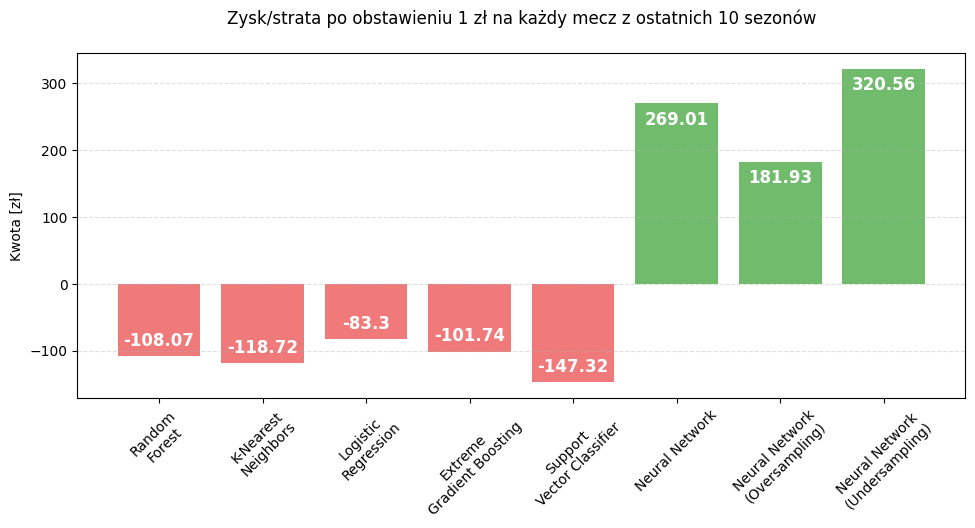

In [143]:
profit_sum = {model: round(sum(profit[model]), 2) for model in profit}

plt.figure(figsize=(10, 6))

bars = plt.bar(profit_sum.keys(), profit_sum.values(), 
               color=['#f07a7a' if value < 0 else colors[2] for value in profit_sum.values()])

plt.ylabel('Kwota [zł]')
plt.title('Zysk/strata po obstawieniu 1 zł na każdy mecz z ostatnich 10 sezonów\n')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)

custom_labels = [
    'Random\nForest', 'K-Nearest\nNeighbors', 'Logistic\nRegression', 'Extreme\nGradient Boosting', 
    'Support\nVector Classifier', 'Neural Network',
    'Neural Network\n(Oversampling)', 'Neural Network\n(Undersampling)'
]
plt.gca().set_xticklabels(custom_labels)

for bar, value in zip(bars, profit_sum.values()):
    if value < 0:
        va = 'bottom'
        y_pos = bar.get_height() + 10
    else:
        va = 'top'
        y_pos = bar.get_height() - 10
    
    plt.text(bar.get_x() + bar.get_width() / 2, 
             y_pos, 
             round(value, 2), 
             ha='center', 
             va=va, 
             color='white',
             weight='bold',
             fontsize=12)

plt.show()

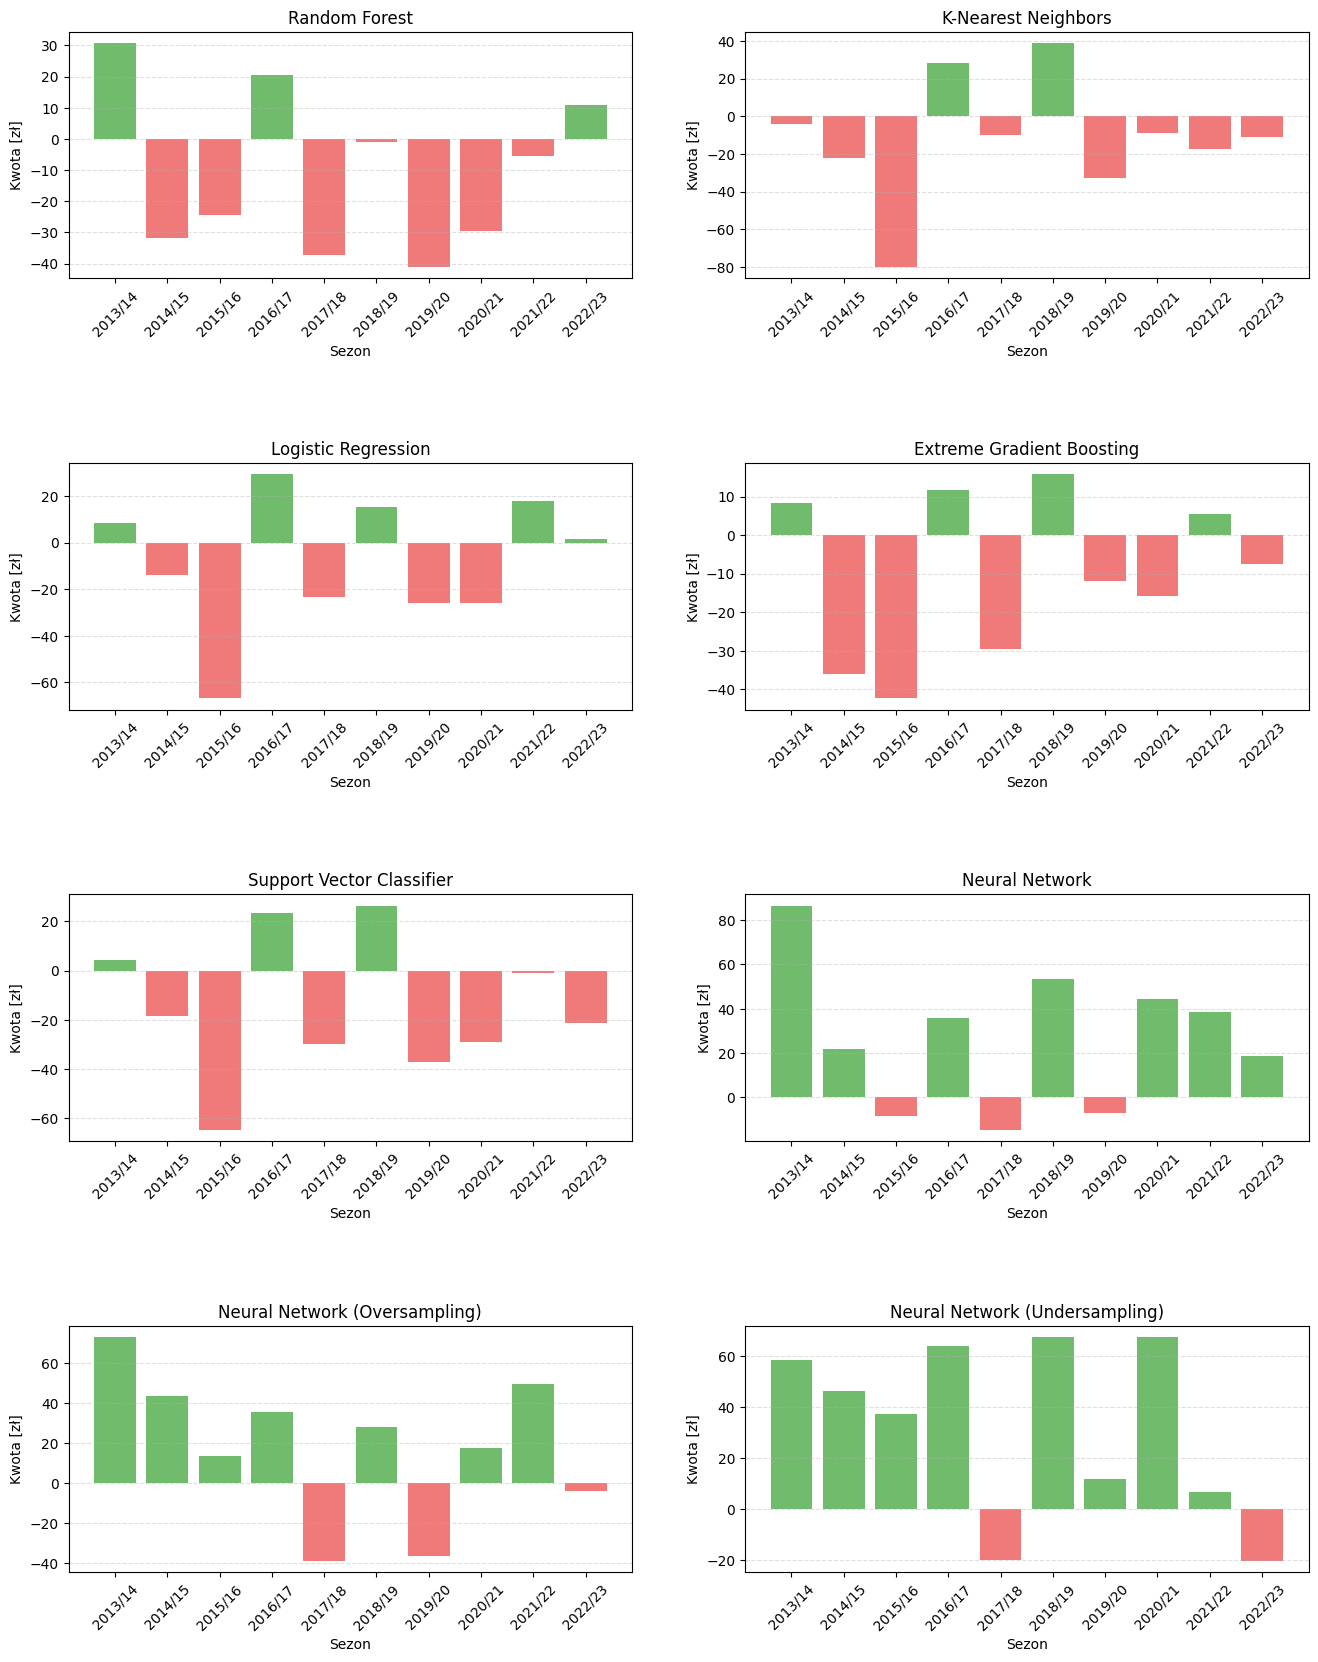

In [145]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20) , gridspec_kw={'hspace': 0.75})

for i, (model, values) in enumerate(profit.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    ax.bar(range(2013, 2023), values, color=['#f07a7a' if value < 0 else colors[2] for value in values])
    ax.set_title(model)
    ax.set_xlabel('Sezon')
    ax.set_ylabel('Kwota [zł]')
    ax.set_xticks(range(2013, 2023))
    ax.set_xticklabels(['2013/14', '2014/15', '2015/16', '2016/17', '2017/18', '2018/19', '2019/20',
                   '2020/21', '2021/22', '2022/23'], rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    
plt.tight_layout()
plt.show()

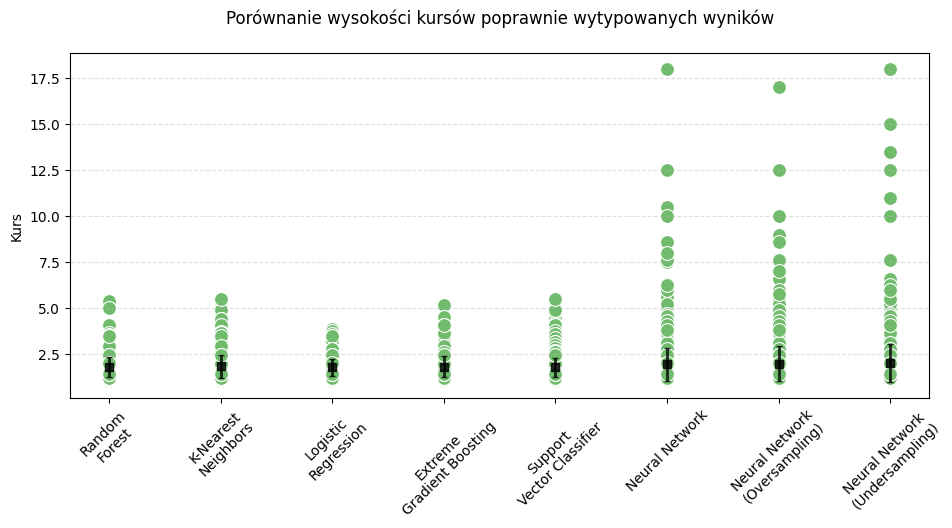

In [144]:
plt.figure(figsize=(10, 6))

max_length = max(len(v) for v in correct_preds_odds.values())
filled_correct_preds_odds = {k: v + [float('nan')] * (max_length - len(v)) for k, v in correct_preds_odds.items()}

odds_df = pd.DataFrame(filled_correct_preds_odds)
melted_df = odds_df.melt(var_name='model', value_name='odds')

scatterplot = sns.scatterplot(data=melted_df, x='model', y='odds', color=colors[2], s=100)

mean_std_by_model = melted_df.groupby('model')['odds'].agg(['mean', 'std']).reset_index()
for i, row in mean_std_by_model.iterrows():
    plt.errorbar(x=row['model'], y=row['mean'], yerr=row['std'], fmt='s', 
                 color='black', capsize=2, elinewidth=2, alpha=0.8)

plt.title('Porównanie wysokości kursów poprawnie wytypowanych wyników\n')
plt.ylabel('Kurs')
plt.xlabel('')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

custom_labels = [
    'Random\nForest', 'K-Nearest\nNeighbors', 'Logistic\nRegression', 'Extreme\nGradient Boosting', 
    'Support\nVector Classifier', 'Neural Network',
    'Neural Network\n(Oversampling)', 'Neural Network\n(Undersampling)'
]
plt.gca().set_xticklabels(custom_labels)

plt.show()